# Aprendizagem Automática Avançada
## Project
### Luís Ferreirinha Nº51227
### Christopher Anaya Nº60566

## Imports

In [13]:
import h5py
import clang.cindex
import json
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score,  matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV

## Data Preprocessing

We start by downloading the Draper dataset from: https://osf.io/d45bw/

This is the dataset we will be analysing in this project, containing over a 1 milion C/C++ function definitions.

In [ ]:
train_dataset = h5py.File('./Dataset/VDISC_train.hdf5')
validation_dataset = h5py.File('./Dataset/VDISC_validate.hdf5')
test_dataset = h5py.File('./Dataset/VDISC_test.hdf5')

Now we will convert these datasets to Pandas

In [ ]:
def convert_to_pandas(dataset):
    data_frame = {
        'code': dataset['functionSource'],
        'CWE-119': dataset['CWE-119'],
        'CWE-120': dataset['CWE-120'],
        'CWE-469': dataset['CWE-469'],
        'CWE-476': dataset['CWE-476'],
        'CWE-OTHERS': dataset['CWE-other'],
    }

    return pd.DataFrame(data=data_frame)

train_pd = convert_to_pandas(train_dataset)
validation_pd = convert_to_pandas(validation_dataset)
test_pd = convert_to_pandas(test_dataset)

We can now take a look at the dataset

In [ ]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,b'visitICmpInst(ICmpInst &I) {\n // We must c...,False,False,False,False,False
1019467,b'path_node_delete_chain(path_node * head)\n{\...,False,False,False,False,False
1019468,b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...,False,False,False,False,False
1019469,"b'Next(const SQObjectPtr &refpos, SQObjectPtr ...",False,False,False,False,False


We need to decode the strings in the code column or else we will have problems later

In [ ]:
train_pd['code'] = train_pd['code'].apply(lambda x: x.decode("utf-8"))
test_pd['code'] = test_pd['code'].apply(lambda x: x.decode("utf-8"))
validation_pd['code'] = validation_pd['code'].apply(lambda x: x.decode("utf-8"))


In [ ]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,visitICmpInst(ICmpInst &I) {\n // We must cas...,False,False,False,False,False
1019467,path_node_delete_chain(path_node * head)\n{\n ...,False,False,False,False,False
1019468,addrconf6_start (NMDevice *self)\n{\n\tNMDevic...,False,False,False,False,False
1019469,"Next(const SQObjectPtr &refpos, SQObjectPtr &o...",False,False,False,False,False


As we can see this dataset is composed of function definition which are classified according to 5 vulnerability categories.  

- CWE-119: Improper Restriction of Operations within the Bounds of a Memory Buffer
- CWE-120: Buffer Overflow
- CWE-469: Use of Pointer Subtraction to Determine Size
- CWE-476: NULL Pointer Dereference
- CWE-Other: mproper Input Validation, Use of Uninitialized Variable, Buffer Access with Incorrect
Length Value, etc.

For the preprocessing and vector embedding processes we will have to join the three datasets. These will later be split before training the models.  

We will also take a 10% split from this dataset in order to later test a mixture model, made from the combination off the models trained on different datasets.

In [ ]:
dataset_joined = pd.concat([train_pd, validation_pd, test_pd], ignore_index=True)
split_90 = dataset_joined.sample(frac = 0.9, random_state = 1)
split_10 = dataset_joined.drop(split_90.index)

## Per-Vulnerability Datasets

Since our goal is to train classifiers for each type of vulnerability present here, we will have to split the dataset into 5 ones, one for each vulnerability.

- CWE-120

In [ ]:
cols_to_drop = ["CWE-119", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_120_df = split_90.drop(cols_to_drop, axis=1)

- CWE-119

In [ ]:
cols_to_drop = ["CWE-120", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_119_df = split_90.drop(cols_to_drop, axis=1)

- CWE-469

In [ ]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-476", "CWE-OTHERS"]
CWE_469_df = split_90.drop(cols_to_drop, axis=1)

- CWE-476

In [ ]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-OTHERS"]
CWE_476_df = split_90.drop(cols_to_drop, axis=1)

- CWE-OTHERS

In [ ]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-476"]
CWE_OTHERS_df = split_90.drop(cols_to_drop, axis=1)

### Unbalanced classes

The dataset we're using contains a great imbalance in the classes

In [ ]:
def plot_classes(dataset, vulnerability):
    shuffled_df = dataset.sample(frac=1,random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability] == False]
    non_normalized_df = pd.concat([vul_df, non_vul_df])
    plt.figure(figsize=(8, 8))
    sns.countplot(x=vulnerability, data=non_normalized_df)
    plt.title('Classes')
    plt.show()

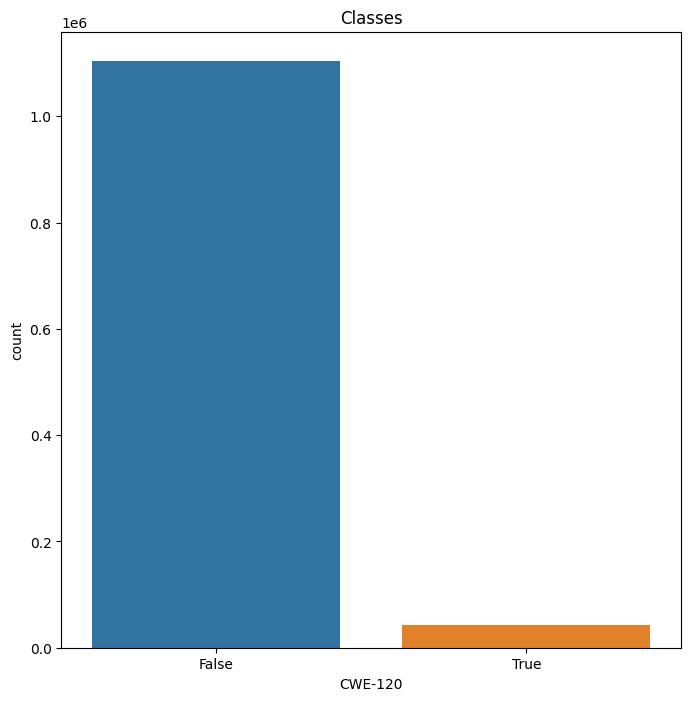

In [ ]:
plot_classes(CWE_120_df, 'CWE-120')

We will have to fix this imbalance in the 5 previous datasets we created. This is important, because an imbalanced dataset will hinder the machine learning models and won't allow us to achieve decent classification results.  

To fix this we will apply under-sampling to generate a 50/50 non-vulnerable:vulnerable subset for each vulnerability dataset.

In [ ]:
def undersample(dataset, vulnerability_class):
    shuffled_df = dataset.sample(frac=1, random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == 0].sample(n=len(vul_df), random_state=42)
    normalized_df = pd.concat([vul_df, non_vul_df])
    return normalized_df

In [ ]:
normalized_CWE_120 = undersample(CWE_120_df, 'CWE-120')
normalized_CWE_119 = undersample(CWE_119_df, 'CWE-119')
normalized_CWE_469 = undersample(CWE_469_df, 'CWE-469')
normalized_CWE_476 = undersample(CWE_476_df, 'CWE-476')
normalized_CWE_OTHERS = undersample(CWE_OTHERS_df, 'CWE-OTHERS')

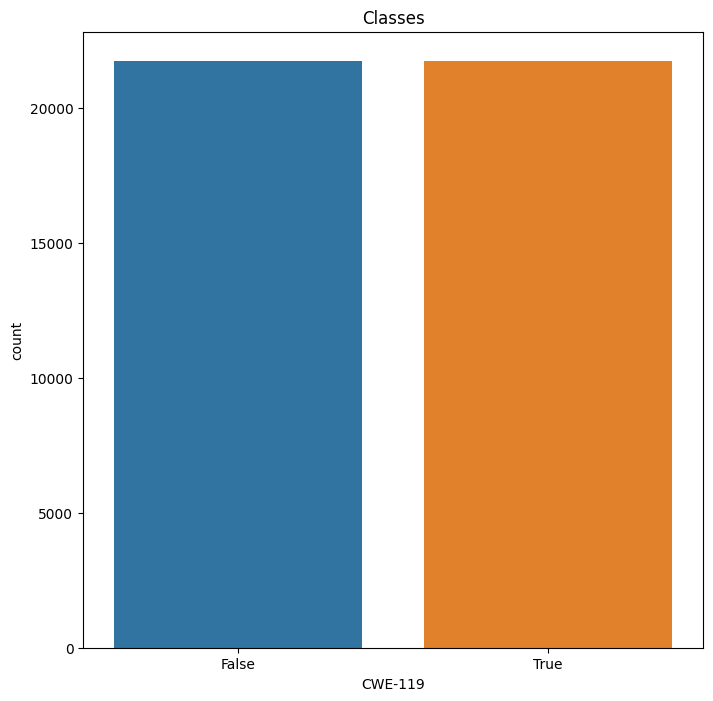

In [ ]:
plot_classes(normalized_CWE_119, 'CWE-119')

Now we will prepare the dataset to be processed by clang and to generate the abstract syntax tree

In [ ]:
def add_column(row):
    return {"filename": str(row.testCase_ID) + "_vdisc.c"}

def prepare_for_clang(dataset, vulnerability):
    dataset.reset_index(inplace=True)
    dataset['type'] = vulnerability
    dataset.columns = ['testCase_ID', 'code', 'vulnerable', 'type']
    dataset['testCase_ID'] = dataset.index
    filenames = dataset.apply(add_column, axis=1, result_type="expand")
    dataset.insert(1, "filename", filenames, True)

In [ ]:
prepare_for_clang(normalized_CWE_119, 'CWE-119')
prepare_for_clang(normalized_CWE_120, 'CWE-120')
prepare_for_clang(normalized_CWE_469, 'CWE-469')
prepare_for_clang(normalized_CWE_476, 'CWE-476')
prepare_for_clang(normalized_CWE_OTHERS, 'CWE-OTHERS')

In [ ]:
normalized_CWE_119

,testCase_ID,filename,code,vulnerable,type
0,0,0_vdisc.c,"fz_paint_shade(fz_context *ctx, fz_shade *shad...",True,CWE-119
1,1,1_vdisc.c,"start_sharing (NMDevice *self, NMIP4Config *co...",True,CWE-119
2,2,2_vdisc.c,plP_getmember(PLStream *pls)\n{\n char tmp[...,True,CWE-119
3,3,3_vdisc.c,snic_stats_debugfs_init(struct snic *snic)\n{\...,True,CWE-119
4,4,4_vdisc.c,folder_lister_addmanually(SCROLL_S *sparms)\n{...,True,CWE-119
...,...,...,...,...,...
43491,43491,43491_vdisc.c,"aggregate_handle_guint64 (CellData *cdata, gui...",False,CWE-119
43492,43492,43492_vdisc.c,asn1PE_H225InfoRequestNakReason (OOCTXT* pctxt...,False,CWE-119
43493,43493,43493_vdisc.c,"fr_archive_create (GFile *file,\n\t\t c...",False,CWE-119
43494,43494,43494_vdisc.c,CPLCleanupTLSList( void **papTLSList )\n\n{\n ...,False,CWE-119


We will save the processed datasets as CSVs to facilitate testing and developtment of this project.  

In [ ]:
normalized_CWE_119.to_csv("./Dataset/preprocessed/vdisc_CWE_119.csv.gz")
normalized_CWE_120.to_csv("./Dataset/preprocessed/vdisc_CWE_120.csv.gz")
normalized_CWE_469.to_csv("./Dataset/preprocessed/vdisc_CWE_469.csv.gz")
normalized_CWE_476.to_csv("./Dataset/preprocessed/vdisc_CWE_476.csv.gz")
normalized_CWE_OTHERS.to_csv("./Dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz")

### Joined dataset

We will also create an aditional dataset with all vulnerabilities combined into one class, vulnerable. This will indicate if the code in question contains any vulnerability.  

To do this, we will convert the False and True into 0 and 1, and apply logical operators (AND and OR)

In [ ]:
split_10

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
40,"aw_input(const char *title, const char *prompt...",False,False,False,False,False
43,"loadProblem(const CoinPackedMatrix& matrix,\n\...",False,False,False,False,False
72,bxt_ddi_vswing_sequence(struct drm_device *dev...,False,False,False,False,False
80,Separator_Draw( menuseparator_s *s )\n{\n\tif ...,False,False,False,False,False
93,"rrule_parse_weekly_days (char *s,\n\t\t\t\t ...",False,False,False,False,False
...,...,...,...,...,...,...
1274318,"FlamePasteData(struct state *st,\n ...",False,True,False,False,True
1274319,"snd_fm801_codec_read(struct snd_ac97 *ac97, un...",False,False,False,False,False
1274334,sq_instanceof(HSQUIRRELVM v)\n{\n\tSQObjectPtr...,False,False,False,False,False
1274342,"update_bias (LqrCarver * r, gint32 layer_ID, g...",False,False,False,False,False


In [ ]:
split_10['CWE-119'] = split_10['CWE-119'].astype(int)
split_10['CWE-120'] = split_10['CWE-120'].astype(int)
split_10['CWE-469'] = split_10['CWE-469'].astype(int)
split_10['CWE-476'] = split_10['CWE-476'].astype(int)
split_10['CWE-OTHERS'] = split_10['CWE-OTHERS'].astype(int)

In [ ]:
# Sum all the values for each vulnerability column into a single column named "vulnerable"
split_10['vulnerable'] = split_10[['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-OTHERS']].sum(axis=1)
# If value in vulnerable is greater than 0, then turn it into True, else turn it into False
split_10['vulnerable'] = split_10['vulnerable'].apply(lambda x: True if x > 0 else False)

In [ ]:
split_10

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS,vulnerable
40,"aw_input(const char *title, const char *prompt...",0,0,0,0,0,False
43,"loadProblem(const CoinPackedMatrix& matrix,\n\...",0,0,0,0,0,False
72,bxt_ddi_vswing_sequence(struct drm_device *dev...,0,0,0,0,0,False
80,Separator_Draw( menuseparator_s *s )\n{\n\tif ...,0,0,0,0,0,False
93,"rrule_parse_weekly_days (char *s,\n\t\t\t\t ...",0,0,0,0,0,False
...,...,...,...,...,...,...,...
1274318,"FlamePasteData(struct state *st,\n ...",0,1,0,0,1,True
1274319,"snd_fm801_codec_read(struct snd_ac97 *ac97, un...",0,0,0,0,0,False
1274334,sq_instanceof(HSQUIRRELVM v)\n{\n\tSQObjectPtr...,0,0,0,0,0,False
1274342,"update_bias (LqrCarver * r, gint32 layer_ID, g...",0,0,0,0,0,False


There is some overlap between vulnerabilities (some samples have more than one), so the final resulting vulnerable samples wont equal the sum of the positive samples for each vulnerability class.

In [ ]:
split_10["vulnerable"].value_counts()

False    119212
True       8225
Name: vulnerable, dtype: int64

Now we can proceed with processing this dataset and saving it.

In [ ]:
cols_to_drop = ["CWE-119", "CWE-120" , "CWE-469", "CWE-476", "CWE-OTHERS"]
joined_df = split_10.drop(cols_to_drop, axis=1)

In [ ]:
joined_df.head()

,code,vulnerable
40,"aw_input(const char *title, const char *prompt...",False
43,"loadProblem(const CoinPackedMatrix& matrix,\n\...",False
72,bxt_ddi_vswing_sequence(struct drm_device *dev...,False
80,Separator_Draw( menuseparator_s *s )\n{\n\tif ...,False
93,"rrule_parse_weekly_days (char *s,\n\t\t\t\t ...",False


In [ ]:
normalized_joined = undersample(joined_df, 'vulnerable')

In [ ]:
prepare_for_clang(normalized_joined, 'vulnerable')

In [ ]:
normalized_joined.head()

,testCase_ID,filename,code,vulnerable,type
0,0,0_vdisc.c,connection_stats(void (*stats_cb)(const char *...,True,vulnerable
1,1,1_vdisc.c,"show_spread(struct device *dev,\n\t\t\t stru...",True,vulnerable
2,2,2_vdisc.c,"bmp_555_888(int fd, struct pixel888 *fb, int w...",True,vulnerable
3,3,3_vdisc.c,OpGetApp()\n{\n cid_getapp_ot in;\n\tch...,True,vulnerable
4,4,4_vdisc.c,"msg_read_data(void *dst, int dstmax, int len, ...",True,vulnerable


In [ ]:
normalized_joined.to_csv("./Dataset/preprocessed/vdisc_combined.csv.gz")

## Extratcing the Abstract Syntax Tree

We will a set of functions to extract the AST of the code for each entry in our dataset. The functions we are using we're originally made by the author of the article which we're using as reference for this project, and use the python biddings for the clang compiler to enable the extraction of the AST.

In [4]:
from ast_extraction_graph2vec import *

Now we convert the CSVs to an AST. This takes some time to run! The AST for each function is saved on a graph2vec/vulnerability directory, and these will serve as input for graph2vec.

In [5]:
graph_Representaion_process("./Dataset/preprocessed/vdisc_CWE_119.csv.gz", "./Dataset/graph2vec/CWE_119/", num_partitions=20)
graph_Representaion_process("./Dataset/preprocessed/vdisc_CWE_120.csv.gz", "./Dataset/graph2vec/CWE_120/", num_partitions=20)
graph_Representaion_process("./Dataset/preprocessed/vdisc_CWE_469.csv.gz", "./Dataset/graph2vec/CWE_469/", num_partitions=20)
graph_Representaion_process("./Dataset/preprocessed/vdisc_CWE_476.csv.gz", "./Dataset/graph2vec/CWE_476/", num_partitions=20)
graph_Representaion_process("./Dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz", "./Dataset/graph2vec/CWE_OTHERS/", num_partitions=20)
graph_Representaion_process("./Dataset/preprocessed/vdisc_combined.csv.gz", "./Dataset/graph2vec/vdisc_combined/", num_partitions=20)

Preprocess source code files and extracting AST's


/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
Current Iteration: 29464
Current Iteration: 29477
Current Iteration: 29488
Current Iteration: 29572
Current Iteration: 29596
Current Iteration: 29597
Current Iteration: 29614
Current Iteration: 29705
Current Iteration: 29722
Current Iteration: 29738
Current Iteration: 29740
Current Iteration: 29752
Current Iteration: 29771
Current Iteration: 29778
Current Iteration: 29780
Current Iteration: 29799
Current Iteration: 29811
Current Iteration: 29817
Current Iteration: 29835
Current Iteration: 29847
Current Iteration: 29870
Current Iteration: 29872
Current Iteration: 29873
Current Iteration: 29908
Current Iteration: 29919
Current Iteration: 29951
Current Iteration: 29986
Current Iteration: 30015
Current Iteration: 30037
Current Iteration: 30045
Current Iteration: 30066
Current Iteration: 30078
Current Iteration: 30089
Current Iteration: 30142
Current Iteration: 30156
Current Iteration: 30169
Current Iteration: 30177
Current Iteratio

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
Current Iteration: 73208
Current Iteration: 73210
Current Iteration: 73214
Current Iteration: 73239
Current Iteration: 73251
Current Iteration: 73252
Current Iteration: 73254
Current Iteration: 73268
Current Iteration: 73274
Current Iteration: 73312
Current Iteration: 73326
Current Iteration: 73365
Current Iteration: 73387
Current Iteration: 73395
Current Iteration: 73404
Current Iteration: 73436
Current Iteration: 73458
Current Iteration: 73460
Current Iteration: 73489
Current Iteration: 73492
Current Iteration: 73499
Current Iteration: 73532
Current Iteration: 73551
Current Iteration: 73572
Current Iteration: 73602
Current Iteration: 73612
Current Iteration: 73649
Current Iteration: 73669
Current Iteration: 73697
Current Iteration: 73762
Current Iteration: 73765
Current Iteration: 73778
Current Iteration: 73792
Current Iteration: 73821
Current Iteration: 73830
Current Iteration: 73845
Current Iteration: 73847
Current Iteratio

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


Current Iteration: 82
Current Iteration: 102
Current Iteration: 111
Current Iteration: 141
Current Iteration: 171
Current Iteration: 197
Current Iteration: 319
Current Iteration: 323
Current Iteration: 337
Current Iteration: 359
Current Iteration: 390
Current Iteration: 407
Current Iteration: 431
Current Iteration: 508
Current Iteration: 555
Current Iteration: 560
Current Iteration: 565
Current Iteration: 704
Current Iteration: 718
Current Iteration: 730
Current Iteration: 748
Current Iteration: 749
Current Iteration: 775
Current Iteration: 779
Current Iteration: 789
Current Iteration: 798
Current Iteration: 833
Current Iteration: 871
Current Iteration: 890
Current Iteration: 899
Current Iteration: 935
Current Iteration: 939
Current Iteration: 940
Current Iteration: 1041
Current Iteration: 1084
Current Iteration: 1131
Current Iteration: 1133
Current Iteration: 1139
Current Iteration: 1180
Current Iteration: 1182
Current Iteration: 1189
Current Iteration: 1234
Current Iteration: 1239
Cu

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
Current Iteration: 8388
Current Iteration: 8394
Current Iteration: 8397
Current Iteration: 8400
Current Iteration: 8401
Current Iteration: 8411
Current Iteration: 8422
Current Iteration: 8423
Current Iteration: 8440
Current Iteration: 8450
Current Iteration: 8457
Current Iteration: 8482
Current Iteration: 8486
Current Iteration: 8496
Current Iteration: 8520
Current Iteration: 8535
Current Iteration: 8541
Current Iteration: 8578
Current Iteration: 8580
Current Iteration: 8592
Current Iteration: 8594
Current Iteration: 8602
Current Iteration: 8621
Current Iteration: 8630
Current Iteration: 8637
Current Iteration: 8647
Current Iteration: 8648
Current Iteration: 8671
Current Iteration: 8679
Current Iteration: 8712
Current Iteration: 8716
Current Iteration: 8739
Current Iteration: 8778
Current Iteration: 8790
Current Iteration: 8843
Current Iteration: 8864
Current Iteration: 8881
Current Iteration: 8901
Current Iteration: 8904
Curre

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
Current Iteration: 24740
Current Iteration: 24741
Current Iteration: 24774
Current Iteration: 24809
Current Iteration: 24828
Current Iteration: 24839
Current Iteration: 24842
Current Iteration: 24860
Current Iteration: 24921
Current Iteration: 25000
Current Iteration: 25020
Current Iteration: 25056
Current Iteration: 25156
Current Iteration: 25205
Current Iteration: 25207
Current Iteration: 25209
Current Iteration: 25223
Current Iteration: 25240
Current Iteration: 25249
Current Iteration: 25322
Current Iteration: 25363
Current Iteration: 25393
Current Iteration: 25394
Current Iteration: 25395
Current Iteration: 25401
Current Iteration: 25479
Current Iteration: 25517
Current Iteration: 25566
Current Iteration: 25570
Current Iteration: 25574
Current Iteration: 25581
Current Iteration: 25583
Current Iteration: 25595
Current Iteration: 25610
Current Iteration: 25628
Current Iteration: 25647
Current Iteration: 25659
Current Iteratio

/usr/local/lib/python3.10/dist-packages/dask/dataframe/core.py:3766: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  warnings.warn(


A saída de streaming foi truncada nas últimas 5000 linhas.
Current Iteration: 14971
Current Iteration: 14994
Current Iteration: 15020
Current Iteration: 15037
Current Iteration: 15047
Current Iteration: 15056
Current Iteration: 15083
Current Iteration: 15092
Current Iteration: 15120
Current Iteration: 15131
Current Iteration: 15155
Current Iteration: 15159
Current Iteration: 15169
Current Iteration: 15194
Current Iteration: 15234
Current Iteration: 15252
Current Iteration: 15276
Current Iteration: 15282
Current Iteration: 15319
Current Iteration: 15340
Current Iteration: 15367
Current Iteration: 15369
Current Iteration: 15408
Current Iteration: 15420
Current Iteration: 15431
Current Iteration: 15461
Current Iteration: 15492
Current Iteration: 15535
Current Iteration: 15556
Current Iteration: 15582
Current Iteration: 15623
Current Iteration: 15648
Current Iteration: 15674
Current Iteration: 15731
Current Iteration: 15732
Current Iteration: 15777
Current Iteration: 15797
Current Iteratio

'./Dataset/graph2vec/vdisc_combined//graph2vec_input/'

## Creating the Vector Embeddings with Graph2vec

To create the vector embedding of the graph structure (Abstract Syntax Tree) we use the following graph2vec library https://github.com/benedekrozemberczki/graph2vec  

The resulting vector embeddings will be saved in the following directory dataset/embeddings/  

In [6]:
!git clone https://github.com/benedekrozemberczki/graph2vec.git

Cloning into 'graph2vec'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 332 (delta 47), reused 37 (delta 37), pack-reused 277
Receiving objects: 100% (332/332), 219.49 KiB | 9.98 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [7]:
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/CWE_119/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_119.csv --epochs 25
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/CWE_120/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_120.csv --epochs 25
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/CWE_469/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_469.csv --epochs 25
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/CWE_476/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_476.csv --epochs 25
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/CWE_OTHERS/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_OTHERS.csv --epochs 25
!python ./graph2vec/src/graph2vec.py --input-path ./Dataset/graph2vec/vdisc_combined/graph2vec_input/ --output ./Dataset/embeddings/vector_CWE_COMBINED.csv --epochs 25


Feature extraction started.

100% 43496/43496 [00:14<00:00, 2956.05it/s]

Optimization started.

/content/./graph2vec/src/graph2vec.py:104: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  out.append([identifier] + list(model.docvecs["g_"+identifier]))

Feature extraction started.

100% 85726/85726 [00:26<00:00, 3211.62it/s]

Optimization started.

/content/./graph2vec/src/graph2vec.py:104: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  out.append([identifier] + list(model.docvecs["g_"+identifier]))

Feature extraction started.

100% 4762/4762 [00:02<00:00, 1588.02it/s]

Optimization started.

/content/./graph2vec/src/graph2vec.py:104: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  out.append([identifier] + list(model.docvecs["g_"+identifier]))

Feature extraction started.

100% 21810/21810 [00:06<00:00, 3287.05it/s]

Optimization

With this new representation of our dataset we can now train regular ML models.

## Creating a dataset on Pytorch Geometric to train the Graph Neural Network

The Graph Neural Network model we will be using, uses the graphs directly for training and for predictions. So inn order to train the Graph Neural Network we will have to extract the ASTs from each C/C++ function and build a dataset on Pytorch Geometric with these graphs.  

We will use the following Dataset class that the author of the original article created.  

In [ ]:
from ast_extraction_pytorch import *

class GraphDataset(Dataset):
    def __init__(self, root, path_dataset, transform=None, pre_transform=None):
        self.path_to_data = path_dataset
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    # Dataset class requires the implementation of this method
    @property
    def processed_file_names(self):
        return 'not_implemented.pt'
    
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.path_to_data)
        for index, vuln in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            data = clang_process_pytorch(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

Now we can create a GraphDataset based on the previously preprocessed datasets. This will also create a folder with all the graphs, one in each file, for the specified root directory.

In [ ]:
graph_CWE_119 = GraphDataset(root='./Dataset/preprocessed/CWE_119', path_dataset='./Dataset/preprocessed/vdisc_CWE_119.csv.gz')
graph_CWE_120 = GraphDataset(root='./Dataset/preprocessed/CWE_120', path_dataset='./Dataset/preprocessed/vdisc_CWE_120.csv.gz')
graph_CWE_469 = GraphDataset(root='./Dataset/preprocessed/CWE_469', path_dataset='./Dataset/preprocessed/vdisc_CWE_469.csv.gz')
graph_CWE_476 = GraphDataset(root='./Dataset/preprocessed/CWE_470', path_dataset='./Dataset/preprocessed/vdisc_CWE_476.csv.gz')
graph_CWE_OTHERS = GraphDataset(root='./Dataset/preprocessed/CWE_OTHERS', path_dataset='./Dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz')
graph_CWE_COMBINED = GraphDataset(root='./Dataset/preprocessed/COMBINED', path_dataset='./Dataset/preprocessed/vdisc_combined.csv.gz')

100%|██████████| 16450/16450 [00:51<00:00, 322.15it/s]


## Training and Validation of Models

Now that we have obtained preprocessed datasets in both embedding and graph format we can create our models and begin training and validating them.

### Graph Neural Network

First let's explore the graph dataset a little bit

In [ ]:
print(f"Number of graphs in dataset: {len(graph_CWE_119)}")
print(f"First Graph Object of the dataset: {graph_CWE_119[1]}")
print(f'Number of nodes: {graph_CWE_119[1].num_nodes}')
print(f'Number of edges: {graph_CWE_119[1].num_edges}')

Number of graphs in dataset: 43496
First Graph Object of the dataset: Data(x=[19, 2], edge_index=[2, 18], y=[1])
Number of nodes: 19
Number of edges: 18


In [ ]:
print(graph_CWE_119[1].edge_index.t())

tensor([[ 0,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 4,  5],
        [ 5,  6],
        [ 4,  7],
        [ 7,  8],
        [ 4,  9],
        [ 9, 10],
        [ 4, 11],
        [11, 12],
        [11, 13],
        [13, 14],
        [13, 15],
        [ 4, 16],
        [16, 17],
        [16, 18]])


In [ ]:
print(graph_CWE_119[1].x)

tensor([[ 1.,  1.],
        [ 2.,  3.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  5.],
        [ 6.,  1.],
        [ 7.,  0.],
        [ 8.,  1.],
        [ 9.,  0.],
        [10.,  1.],
        [11.,  0.],
        [12.,  2.],
        [13.,  0.],
        [14.,  2.],
        [15.,  0.],
        [16.,  0.],
        [17.,  2.],
        [18.,  0.],
        [19.,  0.]])


#### Splitting the dataset

Now we will split the dataset into train (80%), test (10%) and validation (10%)

In [ ]:
#CWE-119
graph_CWE_119 = graph_CWE_119.shuffle()
ten_percent_length = int(len(graph_CWE_119) * 0.1)
train_graphCWE119 = graph_CWE_119[:ten_percent_length * 8]
val_graphCWE119 = graph_CWE_119[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE119 = graph_CWE_119[ten_percent_length * 9:]

#CWE-120
graph_CWE_120 = graph_CWE_120.shuffle()
ten_percent_length = int(len(graph_CWE_120) * 0.1)
train_graphCWE120 = graph_CWE_120[:ten_percent_length * 8]
val_graphCWE120 = graph_CWE_120[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE120 = graph_CWE_120[ten_percent_length * 9:]

#CWE-469
graph_CWE_469 = graph_CWE_469.shuffle()
ten_percent_length = int(len(graph_CWE_469) * 0.1)
train_graphCWE469 = graph_CWE_469[:ten_percent_length * 8]
val_graphCWE469 = graph_CWE_469[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE469 = graph_CWE_469[ten_percent_length * 9:]

#CWE-476
graph_CWE_476 = graph_CWE_476.shuffle()
ten_percent_length = int(len(graph_CWE_476) * 0.1)
train_graphCWE476 = graph_CWE_476[:ten_percent_length * 8]
val_graphCWE476 = graph_CWE_476[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE476 = graph_CWE_476[ten_percent_length * 9:]

#CWE_OTHERS
graph_CWE_OTHERS = graph_CWE_OTHERS.shuffle()
ten_percent_length = int(len(graph_CWE_OTHERS) * 0.1)
train_graphCWEOTHERS = graph_CWE_OTHERS[:ten_percent_length * 8]
val_graphCWEOTHERS = graph_CWE_OTHERS[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWEOTHERS = graph_CWE_OTHERS[ten_percent_length * 9:]

#CWE_COMBINED
graph_CWE_COMBINED = graph_CWE_COMBINED.shuffle()
ten_percent_length = int(len(graph_CWE_COMBINED) * 0.1)
train_graphCWE_COMBINED = graph_CWE_COMBINED[:ten_percent_length * 8]
val_graphCWE_COMBINED = graph_CWE_COMBINED[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE_COMBINED = graph_CWE_COMBINED[ten_percent_length * 9:]

Create dataloaders for PyTorch to iterate over the datasets

In [ ]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 256

# CWE-119 DataLoaders
train_loader_CWE119 = DataLoader(train_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE119 = DataLoader(val_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE119 = DataLoader(test_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-120 DataLoaders
train_loader_CWE120 = DataLoader(train_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE120 = DataLoader(val_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE120 = DataLoader(test_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-469 DataLoaders
train_loader_CWE469 = DataLoader(train_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE469 = DataLoader(val_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE469 = DataLoader(test_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-476 DataLoaders
train_loader_CWE476 = DataLoader(train_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE476 = DataLoader(val_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE476 = DataLoader(test_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-OTHERS DataLoaders
train_loader_CWEOTHERS = DataLoader(train_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWEOTHERS = DataLoader(val_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWEOTHERS = DataLoader(test_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-COMBINED DataLoaders
train_loader_CWE_COMBINED = DataLoader(train_graphCWE_COMBINED, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE_COMBINED = DataLoader(val_graphCWE_COMBINED, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE_COMBINED = DataLoader(test_graphCWE_COMBINED, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Creating the GNN Model

The GNN will be built using PyToch and it follows this architecture:
-     Initial GCNConv layer: Translates input node features into embeddings with a specified embedding size (128 neurons) and applies a ReLU activation function.
-    Two subsequent GCNConv layers: Each with 128 neurons and ReLU activation functions.
-    Global Pooling: Combines global max pooling and global mean pooling to aggregate node features into a single feature representation for each graph.
-    Fully connected (Linear) layers:
     -   First Linear layer: 128 neurons with a ReLU activation function
     -   Second Linear layer: 128 neurons with a ReLU activation function
-    Output Layer: 1 neuron with a Sigmoid activation function

In [ ]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

embedding_size = 128

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        # Initial GCNConv layer: translates our node features into the size of the embedding
        self.initial_conv = GCNConv(2, embedding_size)
        # Two more GCNConv layers to process graph information
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)

        # Output layers
        # Linear layers for classification
        self.lin1 = Linear(embedding_size * 2, 128)
        self.lin2 = Linear(128, 128)
        self.lin3 = Linear(128, 1)

        # Activation functions
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Second Conv layer
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)

        # Third Conv layer
        hidden = self.conv2(hidden, edge_index)

        # Global Pooling (stack different aggregations)
        # Concatenate the global max pool and global mean pool results
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply the final linear classifier layers
        out = self.lin1(hidden)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        out = self.lin3(out)
        out = torch.sigmoid(out)

        return out

Now we will define somes functions to train the GNN, we will be using an early stopping mechanism that stops the training if the validation loss doesn't improve after the specified period (5 epochs by default)

In [ ]:
def train(model, optimizer, loss_fn, train_loader, device):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index, data.batch)
        label = data.y.to(device)
        loss = loss_fn(output.squeeze(), label.float())  
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def evaluate(model, loader, loss_fn, device):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x.float(), data.edge_index, data.batch)
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            predictions.append(np.rint(pred.cpu().detach().numpy()))
            labels.append(label)
            loss = loss_fn(pred.squeeze(), label_true.float())

    predictions = np.concatenate(predictions).ravel()
    labels = np.concatenate(labels).ravel()

    return accuracy_score(labels, predictions), loss

def train_evaluate_GNN(train_loader, val_loader, device, model, optimizer, loss_fn, epochs=200, early_stopping_patience=5):
    print("Starting training...")
    train_losses = []
    val_losses = []
    val_acc_list= []
    train_acc_list= []
    best_loss = 1000
    early_stopping_counter = 0
    for epoch in range(epochs):
        if early_stopping_counter <= early_stopping_patience:
            loss = train(model, optimizer, loss_fn, train_loader, device)
            train_losses.append(loss)
            train_acc, train_loss = evaluate(model, train_loader, loss_fn, device)
            val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)
            val_losses.append(val_loss)
            val_acc_list.append(val_acc)
            train_acc_list.append(train_acc)
        
            if float(val_loss) < best_loss:
                best_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy {train_acc} | Validation Accuracy {val_acc} | Validation loss {val_loss}")

        else:
            print("Early stopping due to no improvement.")
            break
    print(f"Finishing training with best val loss: {best_loss}")

    return train_losses, val_losses, train_acc_list, val_acc_list



#### Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()

- CWE-119

In [ ]:
model_CWE119 = GCN().to(device)
optimizer_CWE119 = torch.optim.Adam(model_CWE119.parameters(), lr=0.01)

train_losses_CWE119, val_losses_CWE119, train_acc_list_CWE119, val_acc_list_CWE119 = train_evaluate_GNN(
    train_loader=train_loader_CWE119,
    val_loader=val_loader_CWE119,
    device=device,
    model=model_CWE119,
    optimizer=optimizer_CWE119,
    loss_fn=loss_fn
)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.6210137711746662 | Train Accuracy 0.6899884259259259 | Validation Accuracy 0.68505859375 | Validation loss 0.6085688471794128


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.5848188781825996 | Train Accuracy 0.6980902777777778 | Validation Accuracy 0.693359375 | Validation loss 0.5516190528869629


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.5818920845984317 | Train Accuracy 0.6999710648148149 | Validation Accuracy 0.697021484375 | Validation loss 0.5812033414840698


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.5742536559272673 | Train Accuracy 0.6978877314814815 | Validation Accuracy 0.699951171875 | Validation loss 0.5630367398262024


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.5693453852130945 | Train Accuracy 0.7078993055555556 | Validation Accuracy 0.7109375 | Validation loss 0.5640164613723755


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.5588997643304765 | Train Accuracy 0.7155671296296297 | Validation Accuracy 0.710693359375 | Validation loss 0.5688924193382263


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.5536814828005624 | Train Accuracy 0.7192418981481481 | Validation Accuracy 0.7158203125 | Validation loss 0.588218092918396


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.5478180130752209 | Train Accuracy 0.7135706018518518 | Validation Accuracy 0.714599609375 | Validation loss 0.586901068687439
Early stopping due to no improvement.
Finishing training with best val loss: 0.5516190528869629


- CWE-120

In [ ]:
model_CWE120 = GCN().to(device)
optimizer_CWE120 = torch.optim.Adam(model_CWE120.parameters(), lr=0.01)

train_losses_CWE120, val_losses_CWE120, train_acc_list_CWE120, val_acc_list_CWE120 = train_evaluate_GNN(
    train_loader=train_loader_CWE120,
    val_loader=val_loader_CWE120,
    device=device,
    model=model_CWE120,
    optimizer=optimizer_CWE120,
    loss_fn=loss_fn
)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.6215750923014333 | Train Accuracy 0.6758397705992509 | Validation Accuracy 0.6719933712121212 | Validation loss 0.6069985628128052


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6072528283283414 | Train Accuracy 0.6764981273408239 | Validation Accuracy 0.6716382575757576 | Validation loss 0.5912307500839233


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6057104156554663 | Train Accuracy 0.6731185627340824 | Validation Accuracy 0.669625946969697 | Validation loss 0.6173311471939087


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6028935006996543 | Train Accuracy 0.6735574672284644 | Validation Accuracy 0.6710464015151515 | Validation loss 0.6194751262664795


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6021681802049175 | Train Accuracy 0.6749473314606742 | Validation Accuracy 0.674124053030303 | Validation loss 0.6488933563232422


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6015643501637753 | Train Accuracy 0.6794826779026217 | Validation Accuracy 0.673532196969697 | Validation loss 0.6213715672492981


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6014732135215543 | Train Accuracy 0.6823501872659176 | Validation Accuracy 0.6773200757575758 | Validation loss 0.6200610995292664


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.598897775978448 | Train Accuracy 0.6800093632958801 | Validation Accuracy 0.6763731060606061 | Validation loss 0.5686906576156616


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.5980535837405762 | Train Accuracy 0.6834474485018727 | Validation Accuracy 0.6821732954545454 | Validation loss 0.5669673681259155


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.5960682785739089 | Train Accuracy 0.6857151217228464 | Validation Accuracy 0.6831202651515151 | Validation loss 0.6024173498153687


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.5957782189533414 | Train Accuracy 0.6884655898876404 | Validation Accuracy 0.6839488636363636 | Validation loss 0.6341145634651184


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11 | Train Loss 0.5934673667343432 | Train Accuracy 0.6868123829588015 | Validation Accuracy 0.6864346590909091 | Validation loss 0.6159697771072388


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 12 | Train Loss 0.5944791236215254 | Train Accuracy 0.6808725421348315 | Validation Accuracy 0.6785037878787878 | Validation loss 0.6288495659828186


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 13 | Train Loss 0.5921435490758187 | Train Accuracy 0.6884070692883895 | Validation Accuracy 0.6857244318181818 | Validation loss 0.6252711415290833


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 14 | Train Loss 0.5911923972346546 | Train Accuracy 0.6885680009363296 | Validation Accuracy 0.6840672348484849 | Validation loss 0.5847835540771484
Early stopping due to no improvement.
Finishing training with best val loss: 0.5669673681259155


- CWE-469

In [ ]:
model_CWE469 = GCN().to(device)
optimizer_CWE469 = torch.optim.Adam(model_CWE469.parameters(), lr=0.01)

train_losses_CWE469, val_losses_CWE469, train_acc_list_CWE469, val_acc_list_CWE469 = train_evaluate_GNN(
    train_loader=train_loader_CWE469,
    val_loader=val_loader_CWE469,
    device=device,
    model=model_CWE469,
    optimizer=optimizer_CWE469,
    loss_fn=loss_fn
)


Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.8020442634069619 | Train Accuracy 0.68359375 | Validation Accuracy 0.7578125 | Validation loss 0.6447069048881531


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.5715585015401119 | Train Accuracy 0.7145647321428571 | Validation Accuracy 0.7265625 | Validation loss 0.5811105370521545


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.5452735804710067 | Train Accuracy 0.7092633928571429 | Validation Accuracy 0.69921875 | Validation loss 0.6048492193222046


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.5410630402444792 | Train Accuracy 0.7117745535714286 | Validation Accuracy 0.734375 | Validation loss 0.5780583620071411


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.5373576428709912 | Train Accuracy 0.7036830357142857 | Validation Accuracy 0.76953125 | Validation loss 0.5973166227340698


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.5438713426349544 | Train Accuracy 0.7126116071428571 | Validation Accuracy 0.671875 | Validation loss 0.6174017190933228


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.5399561689681366 | Train Accuracy 0.7123325892857143 | Validation Accuracy 0.7421875 | Validation loss 0.6139364838600159


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.5413648621374819 | Train Accuracy 0.7151227678571429 | Validation Accuracy 0.72265625 | Validation loss 0.6040449738502502


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.5391811883750082 | Train Accuracy 0.7087053571428571 | Validation Accuracy 0.6875 | Validation loss 0.615388035774231


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.533581120627267 | Train Accuracy 0.7120535714285714 | Validation Accuracy 0.703125 | Validation loss 0.6193586587905884
Early stopping due to no improvement.
Finishing training with best val loss: 0.5780583620071411


- CWE-476

In [ ]:
model_CWE476 = GCN().to(device)
optimizer_CWE476 = torch.optim.Adam(model_CWE476.parameters(), lr=0.01)

train_losses_CWE476, val_losses_CWE476, train_acc_list_CWE476, val_acc_list_CWE476 = train_evaluate_GNN(
    train_loader=train_loader_CWE476,
    val_loader=val_loader_CWE476,
    device=device,
    model=model_CWE476,
    optimizer=optimizer_CWE476,
    loss_fn=loss_fn
)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.7665497326402695 | Train Accuracy 0.5360179227941176 | Validation Accuracy 0.55322265625 | Validation loss 0.6923666000366211


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6839805150021112 | Train Accuracy 0.5596277573529411 | Validation Accuracy 0.580078125 | Validation loss 0.6809156537055969


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6830039577492876 | Train Accuracy 0.5603745404411765 | Validation Accuracy 0.583984375 | Validation loss 0.6880811452865601


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6837073898490336 | Train Accuracy 0.5646829044117647 | Validation Accuracy 0.5849609375 | Validation loss 0.6699744462966919


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6818040754203674 | Train Accuracy 0.5639361213235294 | Validation Accuracy 0.58642578125 | Validation loss 0.6752244234085083


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6808950685678629 | Train Accuracy 0.5616383272058824 | Validation Accuracy 0.56787109375 | Validation loss 0.6873307228088379


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6814442704107607 | Train Accuracy 0.5631318933823529 | Validation Accuracy 0.57666015625 | Validation loss 0.6820604205131531


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.6809064838001894 | Train Accuracy 0.5608340992647058 | Validation Accuracy 0.57470703125 | Validation loss 0.680850088596344


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.6800660365549374 | Train Accuracy 0.5614085477941176 | Validation Accuracy 0.58203125 | Validation loss 0.6803974509239197


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6814963958614302 | Train Accuracy 0.5618106617647058 | Validation Accuracy 0.5673828125 | Validation loss 0.6814320683479309
Early stopping due to no improvement.
Finishing training with best val loss: 0.6699744462966919


- CWE Others

In [ ]:
model_CWEOTHERS = GCN().to(device)
optimizer_CWEOTHERS = torch.optim.Adam(model_CWEOTHERS.parameters(), lr=0.01)

train_losses_CWEOTHERS, val_losses_CWEOTHERS, train_acc_list_CWEOTHERS, val_acc_list_CWEOTHERS = train_evaluate_GNN(
    train_loader=train_loader_CWEOTHERS,
    val_loader=val_loader_CWEOTHERS,
    device=device,
    model=model_CWEOTHERS,
    optimizer=optimizer_CWEOTHERS,
    loss_fn=loss_fn)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.6657421953048525 | Train Accuracy 0.6231361040609137 | Validation Accuracy 0.619140625 | Validation loss 0.6679961681365967


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6521245746173904 | Train Accuracy 0.625832804568528 | Validation Accuracy 0.6295572916666666 | Validation loss 0.6504935026168823


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6529465713924496 | Train Accuracy 0.6279544733502538 | Validation Accuracy 0.63232421875 | Validation loss 0.6319462060928345


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6516975121494326 | Train Accuracy 0.6273992703045685 | Validation Accuracy 0.63134765625 | Validation loss 0.6590188145637512


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.650700365712395 | Train Accuracy 0.6254758883248731 | Validation Accuracy 0.6259765625 | Validation loss 0.6517871618270874


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6499057191974298 | Train Accuracy 0.6268044098984772 | Validation Accuracy 0.6285807291666666 | Validation loss 0.6259350776672363


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6500501510172397 | Train Accuracy 0.6270026967005076 | Validation Accuracy 0.62744140625 | Validation loss 0.6457244753837585


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.648898217717775 | Train Accuracy 0.6157400063451777 | Validation Accuracy 0.6204427083333334 | Validation loss 0.6653738021850586


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.6491771876481107 | Train Accuracy 0.6250396573604061 | Validation Accuracy 0.6271158854166666 | Validation loss 0.6138361692428589


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6488892288268511 | Train Accuracy 0.6291243654822335 | Validation Accuracy 0.63330078125 | Validation loss 0.6624330282211304


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.6484082030644973 | Train Accuracy 0.6283510469543148 | Validation Accuracy 0.6316731770833334 | Validation loss 0.668318510055542


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11 | Train Loss 0.6483978761556506 | Train Accuracy 0.6282717322335025 | Validation Accuracy 0.6337890625 | Validation loss 0.6340604424476624


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 12 | Train Loss 0.6484584106517916 | Train Accuracy 0.6290847081218274 | Validation Accuracy 0.63525390625 | Validation loss 0.6652097702026367


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 13 | Train Loss 0.6478874878123296 | Train Accuracy 0.628053616751269 | Validation Accuracy 0.6315104166666666 | Validation loss 0.6354999542236328


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 14 | Train Loss 0.6501258175492192 | Train Accuracy 0.6242068527918782 | Validation Accuracy 0.6261393229166666 | Validation loss 0.6432005167007446
Early stopping due to no improvement.
Finishing training with best val loss: 0.6138361692428589


- CWE-COMBINED

In [ ]:
model_CWE_COMBINED = GCN().to(device)
optimizer_CWE_COMBINED = torch.optim.Adam(model_CWE_COMBINED.parameters(), lr=0.01)

train_losses_CWE_COMBINED, val_losses_CWE_COMBINED, train_acc_list_CWE_COMBINED, val_acc_list_CWE_COMBINED = train_evaluate_GNN(
    train_loader=train_loader_CWE_COMBINED,
    val_loader=val_loader_CWE_COMBINED,
    device=device,
    model=model_CWE_COMBINED,
    optimizer=optimizer_CWE_COMBINED,
    loss_fn=loss_fn)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.690418461390904 | Train Accuracy 0.6357230392156863 | Validation Accuracy 0.6380208333333334 | Validation loss 0.6656341552734375


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6420471411707915 | Train Accuracy 0.6312040441176471 | Validation Accuracy 0.6334635416666666 | Validation loss 0.6375594139099121


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6398446265687334 | Train Accuracy 0.6384803921568627 | Validation Accuracy 0.64453125 | Validation loss 0.6611689329147339


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6398892469319166 | Train Accuracy 0.635952818627451 | Validation Accuracy 0.6276041666666666 | Validation loss 0.6622885465621948


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6374730026105979 | Train Accuracy 0.6393995098039216 | Validation Accuracy 0.642578125 | Validation loss 0.6522445678710938


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6379807701226788 | Train Accuracy 0.6390931372549019 | Validation Accuracy 0.64453125 | Validation loss 0.640150785446167


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6417451203412923 | Train Accuracy 0.6345741421568627 | Validation Accuracy 0.6295572916666666 | Validation loss 0.6454522609710693


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.6382741272993001 | Train Accuracy 0.6387867647058824 | Validation Accuracy 0.6354166666666666 | Validation loss 0.6363686323165894


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.6374626345185161 | Train Accuracy 0.6329656862745098 | Validation Accuracy 0.6256510416666666 | Validation loss 0.6386170387268066


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6384195750969884 | Train Accuracy 0.6341145833333334 | Validation Accuracy 0.65625 | Validation loss 0.6584535837173462


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.6397818765379375 | Train Accuracy 0.6399356617647058 | Validation Accuracy 0.6380208333333334 | Validation loss 0.6665198802947998


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11 | Train Loss 0.6376740788978646 | Train Accuracy 0.6300551470588235 | Validation Accuracy 0.623046875 | Validation loss 0.6663718223571777


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 12 | Train Loss 0.6364823547177764 | Train Accuracy 0.6409313725490197 | Validation Accuracy 0.6438802083333334 | Validation loss 0.6245271563529968


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 13 | Train Loss 0.6359256060290119 | Train Accuracy 0.6311274509803921 | Validation Accuracy 0.6243489583333334 | Validation loss 0.6363173723220825


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 14 | Train Loss 0.6359297790063551 | Train Accuracy 0.6407781862745098 | Validation Accuracy 0.646484375 | Validation loss 0.6155928373336792


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 15 | Train Loss 0.6361802388107161 | Train Accuracy 0.6393995098039216 | Validation Accuracy 0.6412760416666666 | Validation loss 0.6547470688819885


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 16 | Train Loss 0.6379968834503081 | Train Accuracy 0.6386335784313726 | Validation Accuracy 0.65234375 | Validation loss 0.5873416066169739


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 17 | Train Loss 0.6343309002444375 | Train Accuracy 0.6402420343137255 | Validation Accuracy 0.6341145833333334 | Validation loss 0.6599746942520142


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 18 | Train Loss 0.6351115855764835 | Train Accuracy 0.6383272058823529 | Validation Accuracy 0.640625 | Validation loss 0.6500701904296875


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 19 | Train Loss 0.6341053090196975 | Train Accuracy 0.6396292892156863 | Validation Accuracy 0.6484375 | Validation loss 0.6485307216644287


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 20 | Train Loss 0.6365111064041277 | Train Accuracy 0.6403186274509803 | Validation Accuracy 0.6328125 | Validation loss 0.6109127998352051


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 21 | Train Loss 0.6356243991561936 | Train Accuracy 0.6416973039215687 | Validation Accuracy 0.6399739583333334 | Validation loss 0.6620985269546509


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 22 | Train Loss 0.6355952184613353 | Train Accuracy 0.6394761029411765 | Validation Accuracy 0.640625 | Validation loss 0.6366085410118103
Early stopping due to no improvement.
Finishing training with best val loss: 0.5873416066169739


#### Evaluation

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(train_losses, val_losses, train_acc_list, val_acc_list, cwe_name):
    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
        
        ax1.plot(train_losses, label="train_loss")
        ax1.plot(val_losses, label="val_loss")
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_xlabel('Epochs', fontsize=14)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='best', fontsize=14)
        ax1.set_title(f'{cwe_name} Loss', fontsize=14)

        ax2.plot(train_acc_list, label='train_acc')
        ax2.plot(val_acc_list, label='val_acc')
        ax2.legend(fontsize=14)
        ax2.set_ylabel('Accuracy', fontsize=14)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_title(f'{cwe_name} Accuracy', fontsize=14)

        plt.savefig(f'CWE_{cwe_name}_gnn_losses.png')
        plt.show()


def print_metrics(loader, model):
    #model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred_cpu = pred.cpu()
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            
            accuracy = accuracy_score(label, np.rint(pred_cpu))
            precision = precision_score(label, np.rint(pred_cpu), zero_division=1)
            recall = recall_score(label, np.rint(pred_cpu), zero_division=1)
            f1 = f1_score(label, np.rint(pred_cpu), zero_division=1)
            mcc = matthews_corrcoef(label, np.rint(pred_cpu))
            
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
            print(f"Matthews Correlation: {mcc}")
            print("\nConfusion Matrix:")
            print(confusion_matrix(label, np.rint(pred_cpu)))


- CWE-119

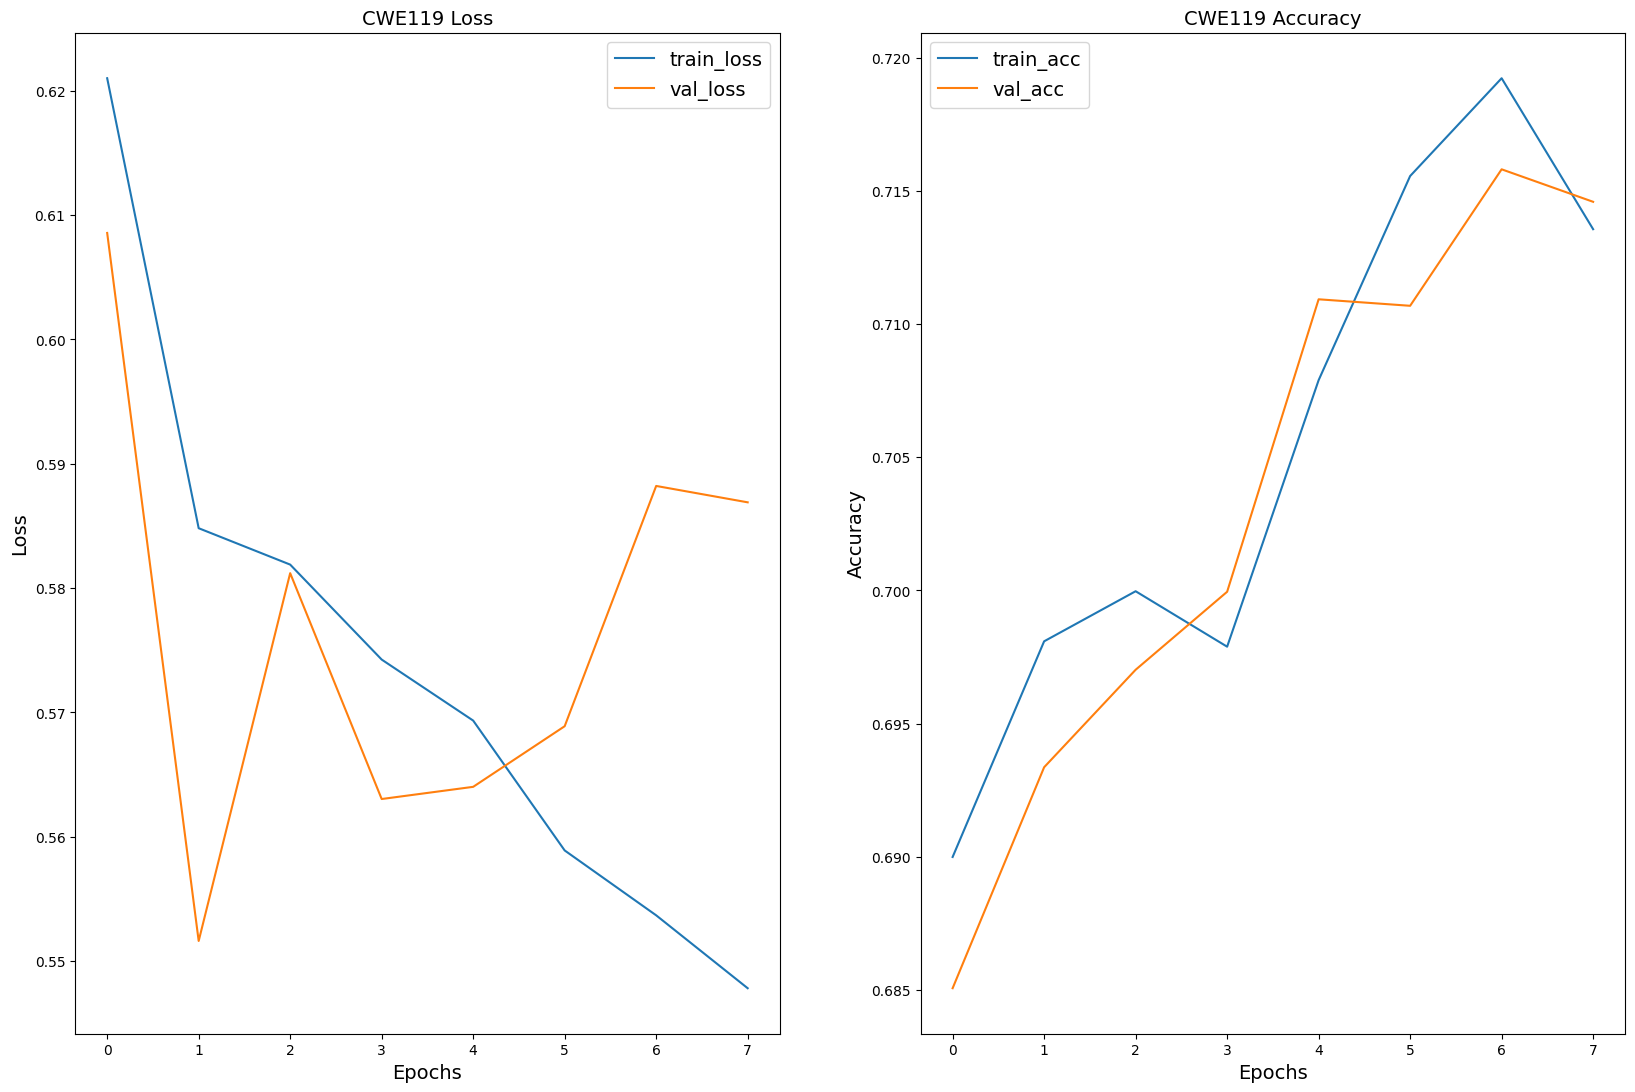

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.7145809414466131
Precision: 0.7758620689655172
Recall: 0.6011054813450023
F1 Score: 0.6773942382559045
Matthews Correlation: 0.4400285242518535

Confusion Matrix:
[[1807  377]
 [ 866 1305]]


In [ ]:
val_losses_CWE119 = [x.item() for x in val_losses_CWE119] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE119, val_losses_CWE119, train_acc_list_CWE119, val_acc_list_CWE119, "CWE119")
test_loader_all_119 = DataLoader(test_graphCWE119, batch_size=len(test_graphCWE119), drop_last=True, shuffle=True)
print_metrics(test_loader_all_119, model_CWE119)

- CWE-120

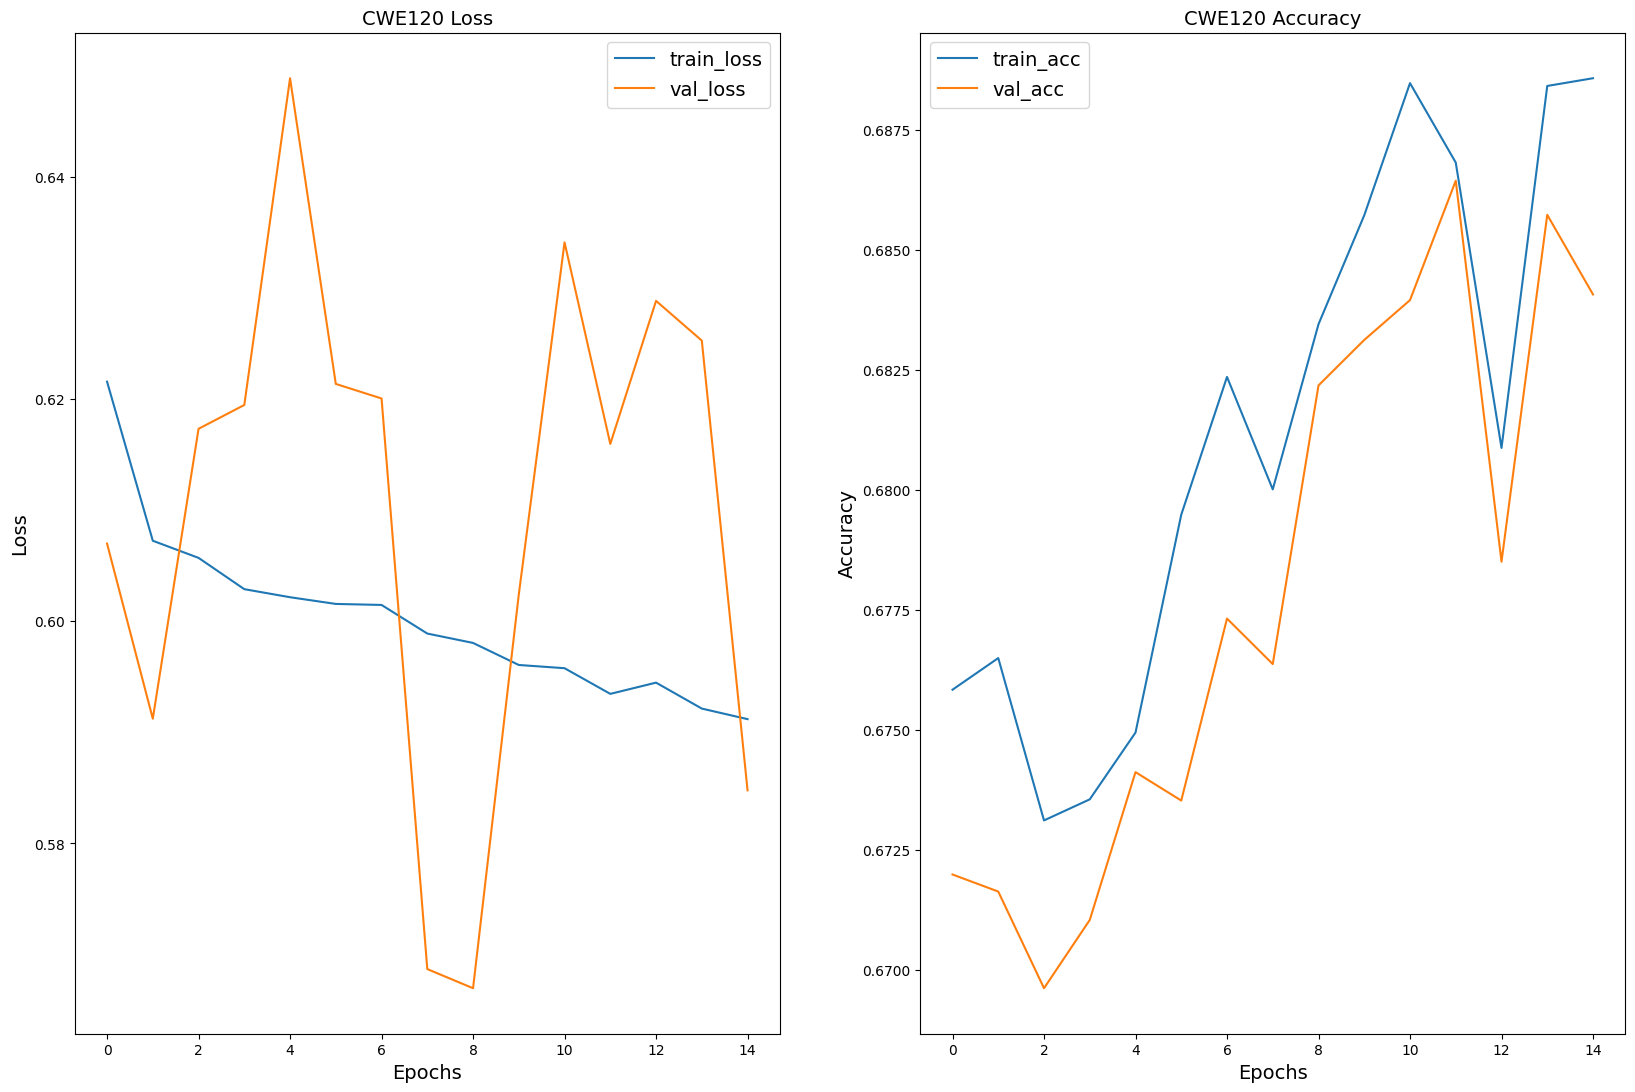

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.686523665190021
Precision: 0.667725540025413
Recall: 0.7378890709103674
F1 Score: 0.7010561423012784
Matthews Correlation: 0.37534421396524414

Confusion Matrix:
[[2736 1569]
 [1120 3153]]


In [ ]:
val_losses_CWE120 = [x.item() for x in val_losses_CWE120] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE120, val_losses_CWE120, train_acc_list_CWE120, val_acc_list_CWE120, "CWE120")
test_loader_all_120 = DataLoader(test_graphCWE120, batch_size=len(test_graphCWE120), drop_last=True, shuffle=True)
print_metrics(test_loader_all_120, model_CWE120)

- CWE-469

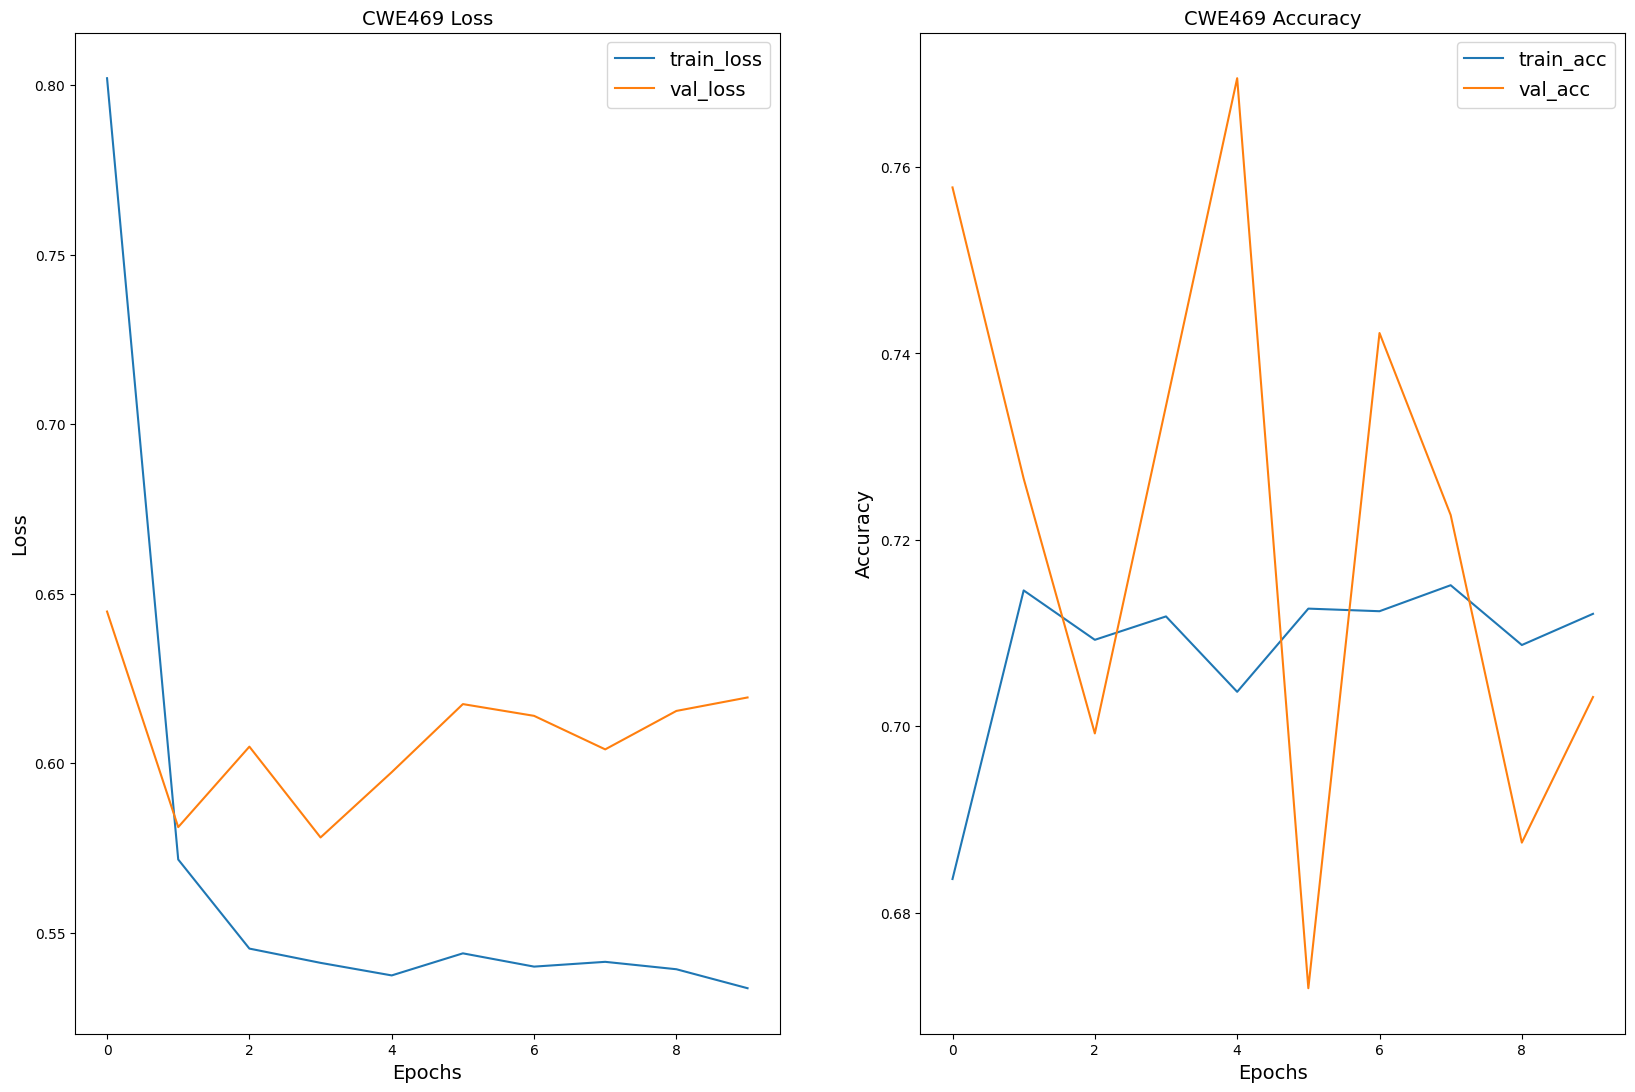

Accuracy: 0.7552301255230126
Precision: 0.7797356828193832
Recall: 0.7254098360655737
F1 Score: 0.751592356687898
Matthews Correlation: 0.5122687384085572

Confusion Matrix:
[[184  50]
 [ 67 177]]


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
val_losses_CWE469 = [x.item() for x in val_losses_CWE469] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE469, val_losses_CWE469, train_acc_list_CWE469, val_acc_list_CWE469, "CWE469")
test_loader_all_469 = DataLoader(test_graphCWE469, batch_size=len(test_graphCWE469), drop_last=True, shuffle=True)
print_metrics(test_loader_all_469, model_CWE469)

- CWE-476

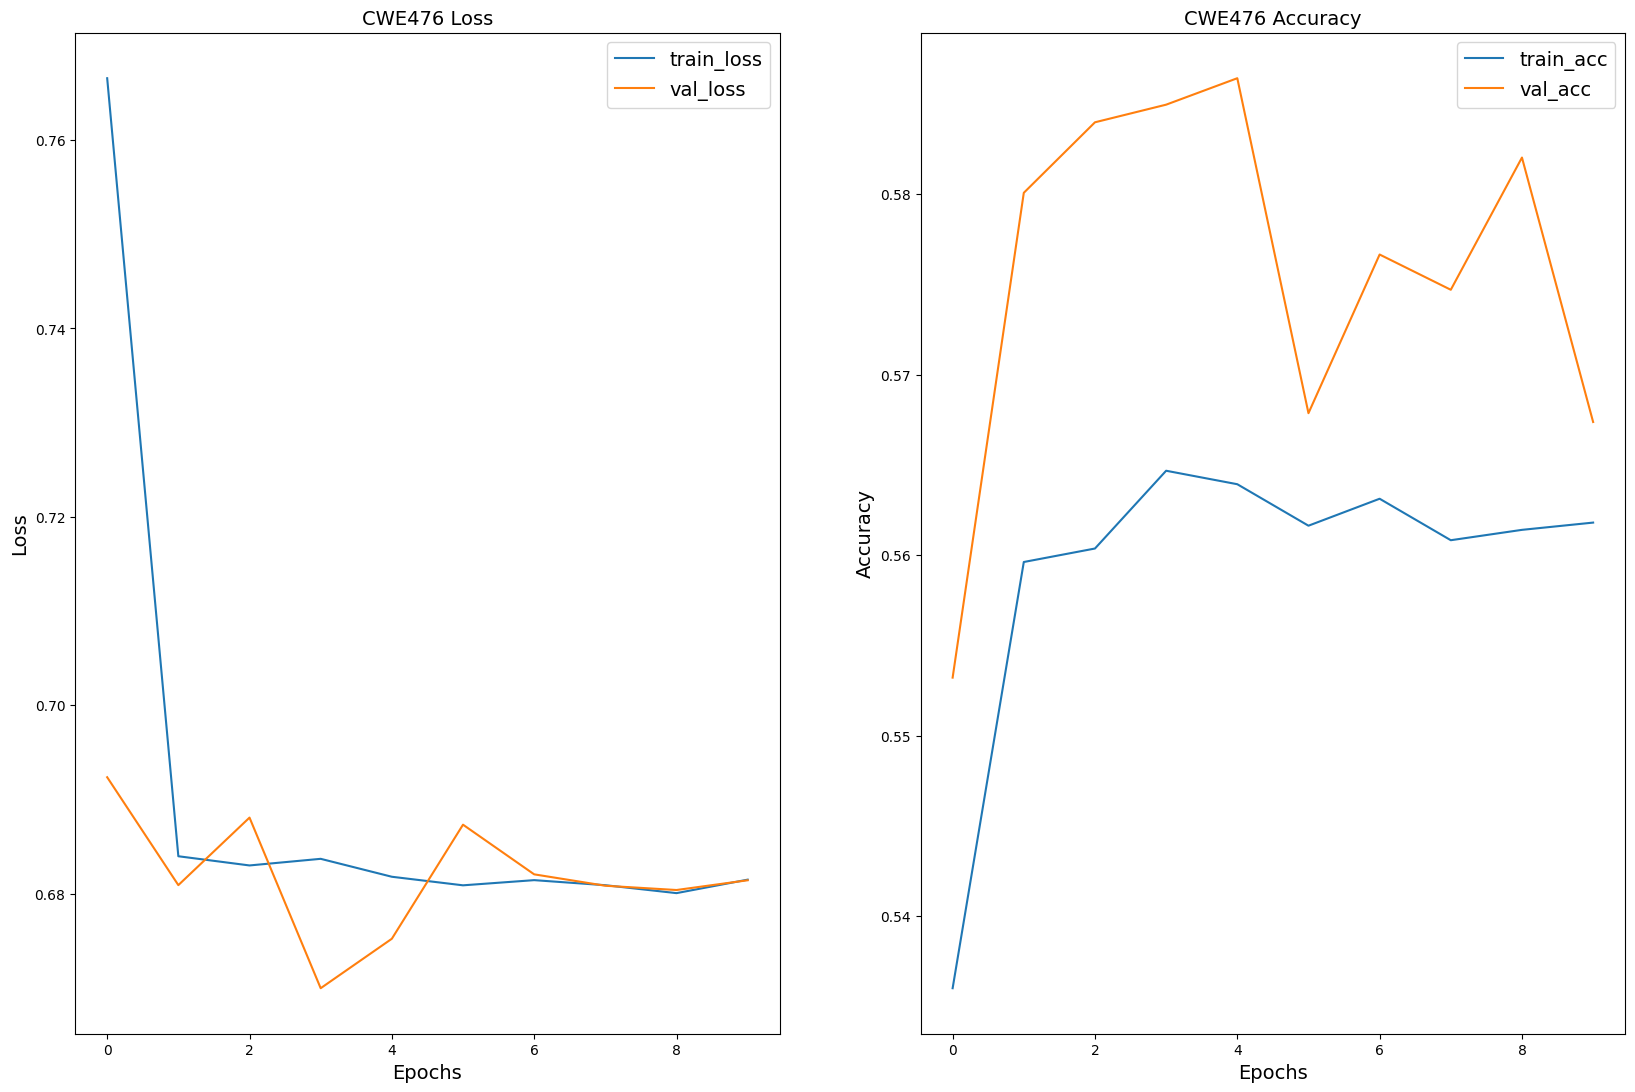

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.5612104539202201
Precision: 0.5486008836524301
Recall: 0.6841138659320477
F1 Score: 0.6089088680016347
Matthews Correlation: 0.12662726381582784

Confusion Matrix:
[[479 613]
 [344 745]]


In [ ]:
val_losses_CWE476 = [x.item() for x in val_losses_CWE476] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE476, val_losses_CWE476, train_acc_list_CWE476, val_acc_list_CWE476, "CWE476")
test_loader_all_476 = DataLoader(test_graphCWE476, batch_size=len(test_graphCWE476), drop_last=True, shuffle=True)
print_metrics(test_loader_all_476, model_CWE476)

- CWE OTHERS

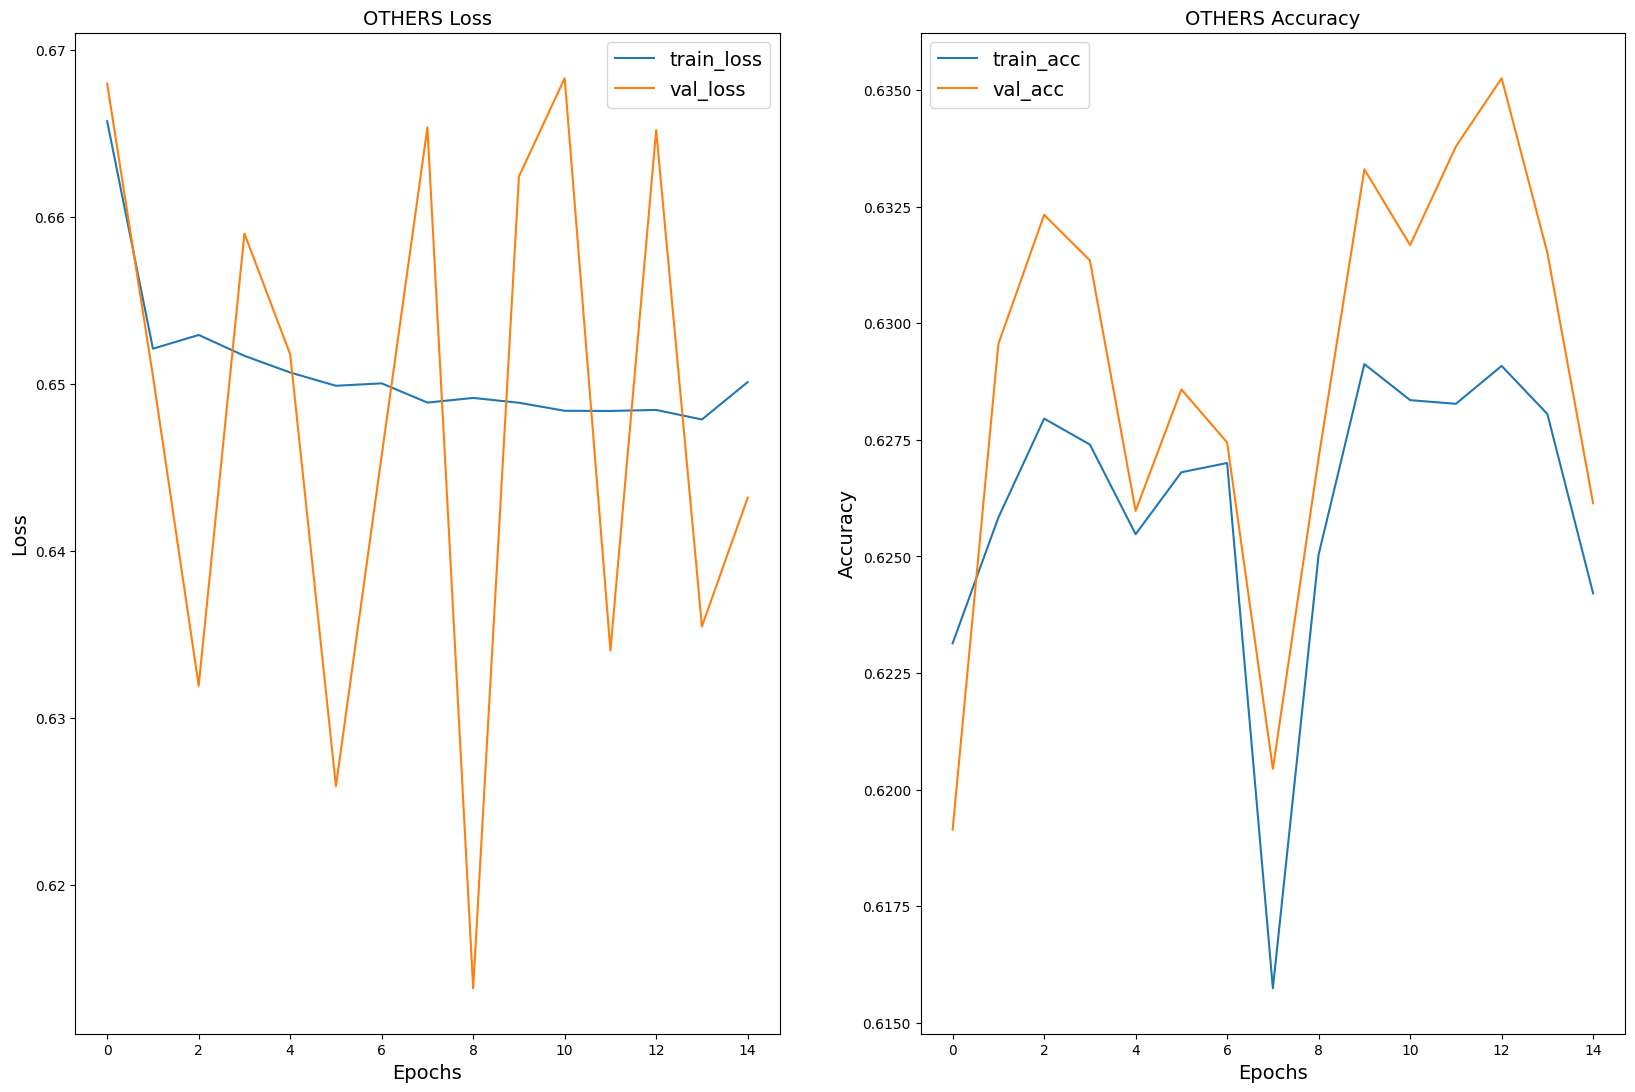

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6348074179743224
Precision: 0.6148429035752979
Recall: 0.7201776649746193
F1 Score: 0.6633547632963179
Matthews Correlation: 0.2737532045713537

Confusion Matrix:
[[1735 1422]
 [ 882 2270]]


In [ ]:
val_losses_CWEOTHERS = [x.item() for x in val_losses_CWEOTHERS] # Transfer values from gpu to cpu
plot_curves(train_losses_CWEOTHERS, val_losses_CWEOTHERS, train_acc_list_CWEOTHERS, val_acc_list_CWEOTHERS, "OTHERS")
test_loader_all_OTHERS = DataLoader(test_graphCWEOTHERS, batch_size=len(test_graphCWEOTHERS), drop_last=True, shuffle=True)
print_metrics(test_loader_all_OTHERS, model_CWEOTHERS)

- CWE-COMBINED

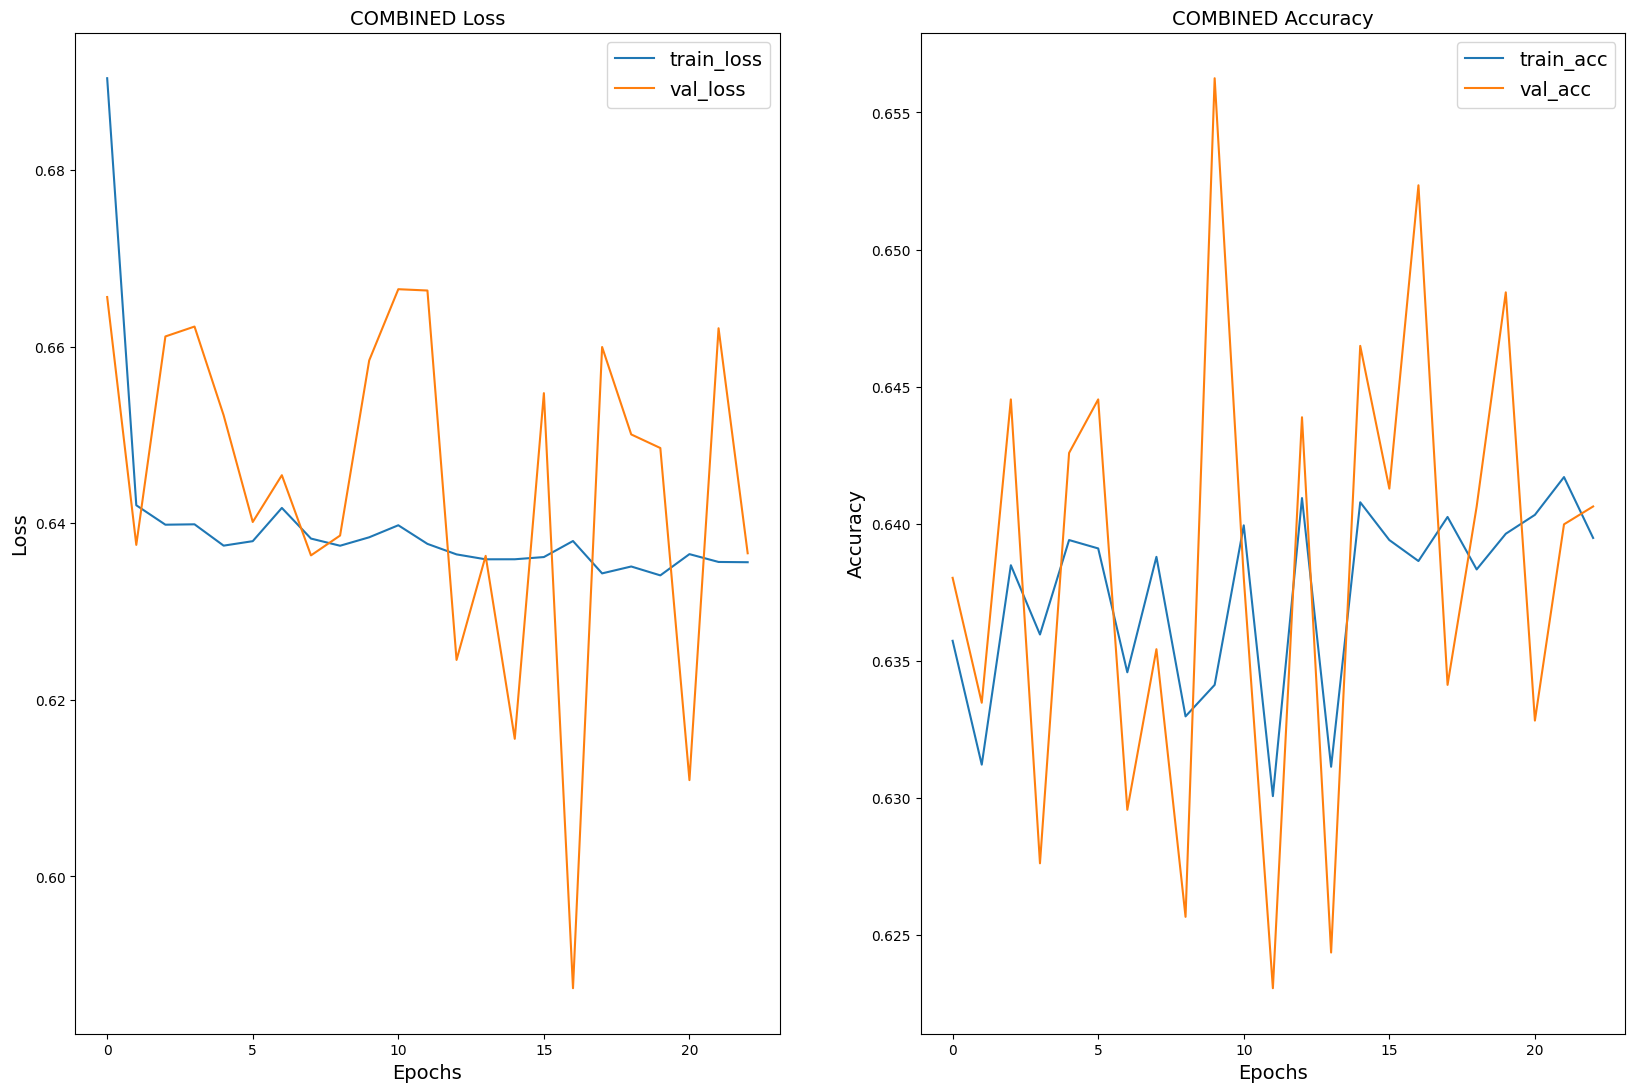

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6407294832826748
Precision: 0.6237942122186495
Recall: 0.708029197080292
F1 Score: 0.6632478632478632
Matthews Correlation: 0.28411636901758885

Confusion Matrix:
[[472 351]
 [240 582]]


In [ ]:
val_losses_CWE_COMBINED = [x.item() for x in val_losses_CWE_COMBINED] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE_COMBINED, val_losses_CWE_COMBINED, train_acc_list_CWE_COMBINED, val_acc_list_CWE_COMBINED, "COMBINED")
test_loader_all_CWE_COMBINED = DataLoader(test_graphCWE_COMBINED, batch_size=len(test_graphCWE_COMBINED), drop_last=True, shuffle=True)
print_metrics(test_loader_all_CWE_COMBINED, model_CWE_COMBINED)

### Graph Neural Network Mixture Models

Now we will join the models trained for each vulnearbility category (119, 120, 469, 475, OTHERS) in a single mixture model. Each individual model will have an assigned weight and this mixture model will be trained on the CWE-COMBINED dataset. Our goal here is to compare a model trained solely on the combined dataset against a mixture model which is made up of experts on different vulnerabilities.  

We will try 3 different types of Mixture models.  

1. Weights: We will apply weights to each of the GNN models and use backpropagation to train this model, the final decision will a weighted sum of outputs of all the models.
2. Averaging: The output will be the average of the models outputs
3. Max: The output will be equal to the max output of the models.

In [ ]:
class MixtureWeightsModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureWeightsModel, self).__init__()
        self.models = torch.nn.ModuleList(models)
        self.weights = torch.nn.Parameter(torch.randn(len(models)))

    def forward(self, x, edge_index, batch_index):
        # Apply each model to the input and detach the result
        outs = [model(x, edge_index, batch_index).detach() for model in self.models]

        # Move results back to the GPU
        outs = [out.to(x.device) for out in outs]

        # Combine the results using learned weights
        out = torch.stack(outs, dim=0)
        weights = torch.nn.functional.softmax(self.weights.to(x.device), dim=0)
        out = torch.sum(weights[:, None, None] * out, dim=0)

        return out

class MixtureAverageModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureAverageModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x, edge_index, batch_index):
        # Apply each model to the input and detach the result
        outs = [model(x, edge_index, batch_index).detach() for model in self.models]

        # Move results back to the original device
        outs = [out.to(x.device) for out in outs]

        # Average the results
        out = torch.mean(torch.stack(outs, dim=0), dim=0)

        return out

class MixtureMaxModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureMaxModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x, edge_index, batch_index):
        # Apply each model to the input and detach the result
        outs = [model(x, edge_index, batch_index).detach() for model in self.models]

        # Move results back to the original device
        outs = [out.to(x.device) for out in outs]

        # Take the maximum of the results
        out = torch.max(torch.stack(outs, dim=0), dim=0)[0]

        return out

Create the new mixture models

In [ ]:
mixture_weights_model = MixtureWeightsModel([model_CWE119, model_CWE120, model_CWE469, model_CWE476, model_CWEOTHERS])
mixture_average_model = MixtureAverageModel([model_CWE119, model_CWE120, model_CWE469, model_CWE476, model_CWEOTHERS])
mixture_max_model = MixtureMaxModel([model_CWE119, model_CWE120, model_CWE469, model_CWE476, model_CWEOTHERS])

Train the weights model (we can reuse the previous training function here)

- Mixture Weights Model

In [ ]:
optimizer = torch.optim.Adam(mixture_weights_model.parameters(), lr=0.01)

train_losses_mixture_weights, val_losses_mixture_weights, train_acc_list_mixture_weights, val_acc_list_mixture_weights = train_evaluate_GNN(
    train_loader=train_loader_CWE_COMBINED,
    val_loader=val_loader_CWE_COMBINED,
    device=device,
    model=model_CWE_COMBINED,
    optimizer=optimizer,
    loss_fn=loss_fn)

Starting training...
Epoch 0 | Train Loss 0.6318477734968655 | Train Accuracy 0.6416207107843137 | Validation Accuracy 0.6458333333333334 | Validation loss 0.6397894620895386


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6315176966704859 | Train Accuracy 0.6418504901960784 | Validation Accuracy 0.6477864583333334 | Validation loss 0.6403818726539612


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6319902854849865 | Train Accuracy 0.6416207107843137 | Validation Accuracy 0.6458333333333334 | Validation loss 0.6245913505554199


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6318511765778608 | Train Accuracy 0.6416973039215687 | Validation Accuracy 0.64453125 | Validation loss 0.6665095090866089


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6320511339645618 | Train Accuracy 0.6413143382352942 | Validation Accuracy 0.6471354166666666 | Validation loss 0.6201922297477722


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6317654409669453 | Train Accuracy 0.641390931372549 | Validation Accuracy 0.6477864583333334 | Validation loss 0.6427828669548035


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6321000768783245 | Train Accuracy 0.6422334558823529 | Validation Accuracy 0.6412760416666666 | Validation loss 0.6275715827941895


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.6316754604907746 | Train Accuracy 0.6419270833333334 | Validation Accuracy 0.6458333333333334 | Validation loss 0.6226344108581543


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.6318902580933731 | Train Accuracy 0.6423866421568627 | Validation Accuracy 0.6438802083333334 | Validation loss 0.6425020694732666


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6316126884298122 | Train Accuracy 0.6417738970588235 | Validation Accuracy 0.6419270833333334 | Validation loss 0.6547627449035645


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.6319638133411349 | Train Accuracy 0.6412377450980392 | Validation Accuracy 0.6419270833333334 | Validation loss 0.6699491143226624
Early stopping due to no improvement.
Finishing training with best val loss: 0.6201922297477722


Model evaluation

- Weights Model

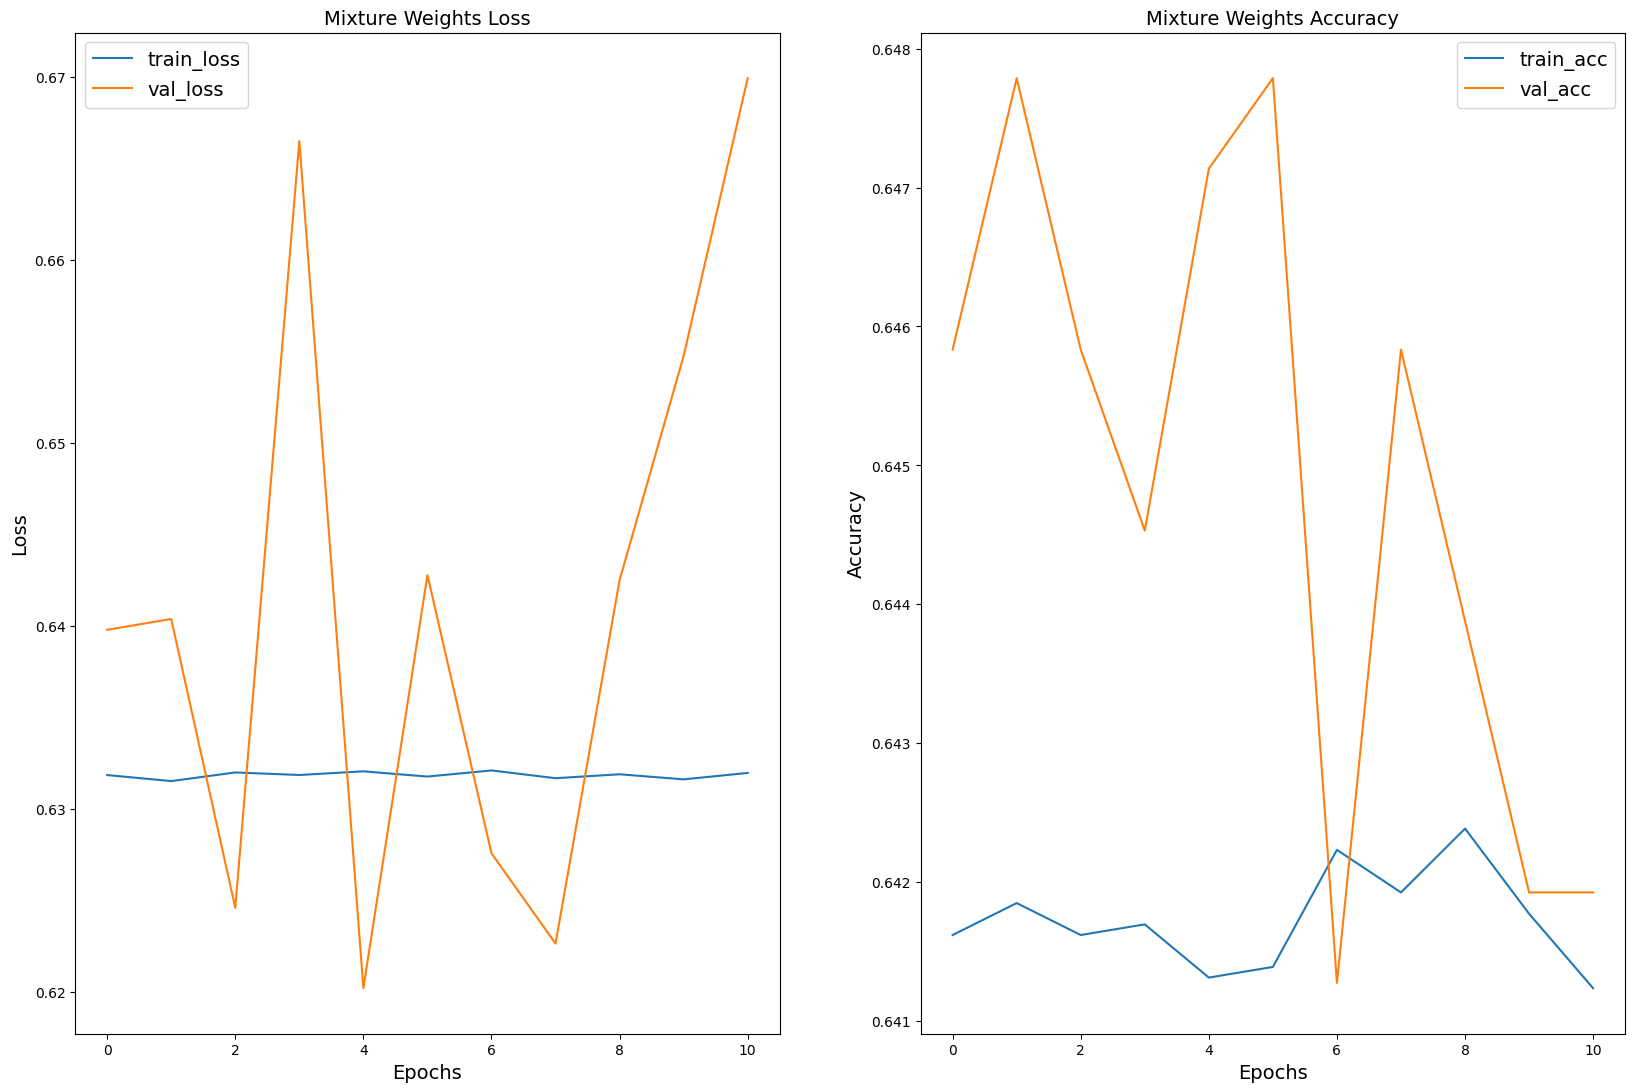

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6401215805471124
Precision: 0.7017543859649122
Recall: 0.48661800486618007
F1 Score: 0.5747126436781609
Matthews Correlation: 0.29426597341505634

Confusion Matrix:
[[653 170]
 [422 400]]


In [ ]:
val_losses_mixture = [x.item() for x in val_losses_mixture_weights] # Transfer values from gpu to cpu
plot_curves(train_losses_mixture_weights, val_losses_mixture, train_acc_list_mixture_weights, val_acc_list_mixture_weights, "Mixture Weights")
test_loader_all_CWE_COMBINED = DataLoader(test_graphCWE_COMBINED, batch_size=len(test_graphCWE_COMBINED), drop_last=True, shuffle=True)
print_metrics(test_loader_all_CWE_COMBINED, mixture_weights_model)

Model weights

In [ ]:
weights = torch.nn.functional.softmax(mixture_weights_model.weights, dim=0)

print(f"Weights:\nCWE-119: {weights[0]}\nCWE-120: {weights[1]}\nCWE-469: {weights[2]}\nCWE-476: {weights[3]}\nCWE-OTHERS: {weights[4]}")

Weights:
CWE-119: 0.5812662243843079
CWE-120: 0.21982859075069427
CWE-469: 0.0417611226439476
CWE-476: 0.09585603326559067
CWE-OTHERS: 0.06128804758191109


- Mixture Averaging Model

In [ ]:
test_loader_all_CWE_COMBINED = DataLoader(test_graphCWE_COMBINED, batch_size=len(test_graphCWE_COMBINED), drop_last=True, shuffle=True)
print_metrics(test_loader_all_CWE_COMBINED, mixture_average_model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6474164133738601
Precision: 0.6657534246575343
Recall: 0.5912408759124088
F1 Score: 0.6262886597938144
Matthews Correlation: 0.2966464326288765

Confusion Matrix:
[[579 244]
 [336 486]]


- Mixture Max Model

In [ ]:
test_loader_all_CWE_COMBINED = DataLoader(test_graphCWE_COMBINED, batch_size=len(test_graphCWE_COMBINED), drop_last=True, shuffle=True)
print_metrics(test_loader_all_CWE_COMBINED, mixture_max_model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6164133738601824
Precision: 0.5862691960252936
Recall: 0.7895377128953771
F1 Score: 0.6728875064800416
Matthews Correlation: 0.24836818019466125

Confusion Matrix:
[[365 458]
 [173 649]]


### Multilayer Perceptron

#### Labelling and Splitting dataset

Before we train we must add the correct labels of each sample in each dataset to the embedded datasets.

In [14]:
# Preprocessed datasets for labels
preprocesed_CWE119 = pd.read_csv("./Dataset/preprocessed/vdisc_CWE_119.csv.gz")
preprocesed_CWE120 = pd.read_csv("./Dataset/preprocessed/vdisc_CWE_120.csv.gz")
preprocesed_CWE469 = pd.read_csv("./Dataset/preprocessed/vdisc_CWE_469.csv.gz")
preprocesed_CWE476 = pd.read_csv("./Dataset/preprocessed/vdisc_CWE_476.csv.gz")
preprocesed_CWEOTHERS = pd.read_csv("./Dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz")
preprocesed_COMBINED = pd.read_csv("./Dataset/preprocessed/vdisc_combined.csv.gz")
# Embedded dataset
embedded_CWE119 = pd.read_csv("./Dataset/embeddings/vector_CWE_119.csv")
embedded_CWE120 = pd.read_csv("./Dataset/embeddings/vector_CWE_120.csv")
embedded_CWE469 = pd.read_csv("./Dataset/embeddings/vector_CWE_469.csv")
embedded_CWE476 = pd.read_csv("./Dataset/embeddings/vector_CWE_476.csv")
embedded_CWEOTHERS = pd.read_csv("./Dataset/embeddings/vector_CWE_OTHERS.csv")
embedded_COMBINED = pd.read_csv("./Dataset/embeddings/vector_CWE_COMBINED.csv")


Convert the true and false values for the feature "vulnerable" to 1 and 0, respectively

In [15]:
preprocesed_CWE119["vulnerable"] = preprocesed_CWE119["vulnerable"].astype(int)
preprocesed_CWE120["vulnerable"] = preprocesed_CWE120["vulnerable"].astype(int)
preprocesed_CWE469["vulnerable"] = preprocesed_CWE469["vulnerable"].astype(int)
preprocesed_CWE476["vulnerable"] = preprocesed_CWE476["vulnerable"].astype(int)
preprocesed_CWEOTHERS["vulnerable"] = preprocesed_CWEOTHERS["vulnerable"].astype(int)
preprocesed_COMBINED["vulnerable"] = preprocesed_COMBINED["vulnerable"].astype(int)

In [16]:
preprocesed_CWE119

,Unnamed: 0,testCase_ID,filename,code,vulnerable,type
0,0,0,0_vdisc.c,"fz_paint_shade(fz_context *ctx, fz_shade *shad...",1,CWE-119
1,1,1,1_vdisc.c,"start_sharing (NMDevice *self, NMIP4Config *co...",1,CWE-119
2,2,2,2_vdisc.c,plP_getmember(PLStream *pls)\n{\n char tmp[...,1,CWE-119
3,3,3,3_vdisc.c,snic_stats_debugfs_init(struct snic *snic)\n{\...,1,CWE-119
4,4,4,4_vdisc.c,folder_lister_addmanually(SCROLL_S *sparms)\n{...,1,CWE-119
...,...,...,...,...,...,...
43491,43491,43491,43491_vdisc.c,"aggregate_handle_guint64 (CellData *cdata, gui...",0,CWE-119
43492,43492,43492,43492_vdisc.c,asn1PE_H225InfoRequestNakReason (OOCTXT* pctxt...,0,CWE-119
43493,43493,43493,43493_vdisc.c,"fr_archive_create (GFile *file,\n\t\t c...",0,CWE-119
43494,43494,43494,43494_vdisc.c,CPLCleanupTLSList( void **papTLSList )\n\n{\n ...,0,CWE-119


Now we will get the labels from the preprocessed dataset and add them to the embedded one, this way we can use the dataset to train and validate classifiers.

In [17]:
# Get classes for each dataset
y_CWE119 = preprocesed_CWE119.iloc[:,4]
y_CWE120 = preprocesed_CWE120.iloc[:,4]
y_CWE469 = preprocesed_CWE469.iloc[:,4]
y_CWE476 = preprocesed_CWE476.iloc[:,4]
y_CWEOTHERS = preprocesed_CWEOTHERS.iloc[:,4]
y_COMBINED = preprocesed_COMBINED.iloc[:,4]
# Drop the column type (which is an index column basicly)
x_CWE119 = embedded_CWE119.drop(columns="type")
x_CWE120 = embedded_CWE120.drop(columns="type")
x_CWE469 = embedded_CWE469.drop(columns="type")
x_CWE476 = embedded_CWE476.drop(columns="type")
x_CWEOTHERS = embedded_CWEOTHERS.drop(columns="type")
x_COMBINED = embedded_COMBINED.drop(columns="type")

Split the datasets into train (80%), test (10%) and validation (10%)

In [18]:
# CWE-119
x_CWE119_train, x_CWE119_test, y_CWE119_train, y_CWE119_test = train_test_split(x_CWE119, y_CWE119, test_size=0.2, random_state=1)
x_CWE119_train, x_CWE119_validation, y_CWE119_train, y_CWE119_validation = train_test_split(x_CWE119_train, y_CWE119_train, test_size=0.25, random_state=1)
# CWE-120
x_CWE120_train, x_CWE120_test, y_CWE120_train, y_CWE120_test = train_test_split(x_CWE120, y_CWE120, test_size=0.2, random_state=1)
x_CWE120_train, x_CWE120_validation, y_CWE120_train, y_CWE120_validation = train_test_split(x_CWE120_train, y_CWE120_train, test_size=0.25, random_state=1)
# CWE-469
x_CWE469_train, x_CWE469_test, y_CWE469_train, y_CWE469_test = train_test_split(x_CWE469, y_CWE469, test_size=0.2, random_state=1)
x_CWE469_train, x_CWE469_validation, y_CWE469_train, y_CWE469_validation = train_test_split(x_CWE469_train, y_CWE469_train, test_size=0.25, random_state=1)
# CWE-476
x_CWE476_train, x_CWE476_test, y_CWE476_train, y_CWE476_test = train_test_split(x_CWE476, y_CWE476, test_size=0.2, random_state=1)
x_CWE476_train, x_CWE476_validation, y_CWE476_train, y_CWE476_validation = train_test_split(x_CWE476_train, y_CWE476_train, test_size=0.25, random_state=1)
# CWE-OTHERS
x_CWEOTHERS_train, x_CWEOTHERS_test, y_CWEOTHERS_train, y_CWEOTHERS_test = train_test_split(x_CWEOTHERS, y_CWEOTHERS, test_size=0.2, random_state=1)
x_CWEOTHERS_train, x_CWEOTHERS_validation, y_CWEOTHERS_train, y_CWEOTHERS_validation = train_test_split(x_CWEOTHERS_train, y_CWEOTHERS_train, test_size=0.25, random_state=1)
# CWE-COMBINED
x_COMBINED_train, x_COMBINED_test, y_COMBINED_train, y_COMBINED_test = train_test_split(x_COMBINED, y_COMBINED, test_size=0.2, random_state=1)
x_COMBINED_train, x_COMBINED_validation, y_COMBINED_train, y_COMBINED_validation = train_test_split(x_COMBINED_train, y_COMBINED_train, test_size=0.25, random_state=1)

Now we create tensors, we will be using tensors because our MLP model will be created with PyTorch

In [19]:
# CWE-119
x_CWE119_train_tensors = torch.FloatTensor(x_CWE119_train.values)
x_CWE119_test_tensors = torch.FloatTensor(x_CWE119_test.values)
x_CWE119_val_tensors = torch.FloatTensor(x_CWE119_validation.values)
y_CWE119_train_tensors = torch.tensor(y_CWE119_train.values)
y_CWE119_test_tensors = torch.tensor(y_CWE119_test.values)
y_CWE119_val_tensors = torch.tensor(y_CWE119_validation.values)

# CWE-120
x_CWE120_train_tensors = torch.FloatTensor(x_CWE120_train.values)
x_CWE120_test_tensors = torch.FloatTensor(x_CWE120_test.values)
x_CWE120_val_tensors = torch.FloatTensor(x_CWE120_validation.values)
y_CWE120_train_tensors = torch.tensor(y_CWE120_train.values)
y_CWE120_test_tensors = torch.tensor(y_CWE120_test.values)
y_CWE120_val_tensors = torch.tensor(y_CWE120_validation.values)

# CWE-469
x_CWE469_train_tensors = torch.FloatTensor(x_CWE469_train.values)
x_CWE469_test_tensors = torch.FloatTensor(x_CWE469_test.values)
x_CWE469_val_tensors = torch.FloatTensor(x_CWE469_validation.values)
y_CWE469_train_tensors = torch.tensor(y_CWE469_train.values)
y_CWE469_test_tensors = torch.tensor(y_CWE469_test.values)
y_CWE469_val_tensors = torch.tensor(y_CWE469_validation.values)

# CWE-476
x_CWE476_train_tensors = torch.FloatTensor(x_CWE476_train.values)
x_CWE476_test_tensors = torch.FloatTensor(x_CWE476_test.values)
x_CWE476_val_tensors = torch.FloatTensor(x_CWE476_validation.values)
y_CWE476_train_tensors = torch.tensor(y_CWE476_train.values)
y_CWE476_test_tensors = torch.tensor(y_CWE476_test.values)
y_CWE476_val_tensors = torch.tensor(y_CWE476_validation.values)

# CWE-OTHERS
x_CWEOTHERS_train_tensors = torch.FloatTensor(x_CWEOTHERS_train.values)
x_CWEOTHERS_test_tensors = torch.FloatTensor(x_CWEOTHERS_test.values)
x_CWEOTHERS_val_tensors = torch.FloatTensor(x_CWEOTHERS_validation.values)
y_CWEOTHERS_train_tensors = torch.tensor(y_CWEOTHERS_train.values)
y_CWEOTHERS_test_tensors = torch.tensor(y_CWEOTHERS_test.values)
y_CWEOTHERS_val_tensors = torch.tensor(y_CWEOTHERS_validation.values)

# CWE-COMBINED
x_COMBINED_train_tensors = torch.FloatTensor(x_COMBINED_train.values)
x_COMBINED_test_tensors = torch.FloatTensor(x_COMBINED_test.values)
x_COMBINED_val_tensors = torch.FloatTensor(x_COMBINED_validation.values)
y_COMBINED_train_tensors = torch.tensor(y_COMBINED_train.values)
y_COMBINED_test_tensors = torch.tensor(y_COMBINED_test.values)
y_COMBINED_val_tensors = torch.tensor(y_COMBINED_validation.values)


#### Creating the model

Now we will create the MLP model in PyTorch. We will be following the same architecture the author of the article used.

NN Architecture:  
- Input Layer: 128 Neurons with a ReLU activation function
- Hidden Layer: 128 Neurons with a ReLU activation function
- Output Lyaer: 1 Neuron with a Sigmoid activation function

In [20]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

To train this model we will first have to define some functions.  

Here we define functions to evaluate and train one epoch, which will be intregrated into the train_model function which will be in charge of training the model for the specified number of epochs or until it there is no improvement in the validation loss after the early_stopping_patience period defined.  

And finally a train cwe function to avoid repeating the same code for each dataset.

In [21]:
def evaluate(x_tensors, y_tensors, model, criterion):
    model.eval()
    y_pred = model(x_tensors)
    loss  = criterion(y_pred.squeeze(), y_tensors.float()) 
    return accuracy_score(y_tensors.detach().cpu().numpy(), np.rint(y_pred.cpu().detach().numpy())), loss

def train(x_train_tensors, y_train_tensors, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_tensors)    
    loss = criterion(y_pred.squeeze(), y_train_tensors.float())
    loss.backward()
    optimizer.step()
    return loss

def train_model(epochs, early_stopping_patience, train_function, evaluate_function, x_train_tensors, y_train_tensors, x_val_tensors, y_val_tensors, model, criterion, optimizer):
    print("Starting training...")
    train_losses = []
    val_losses = []
    val_acc_list = []
    train_acc_list = []
    best_loss = 1000
    early_stopping_counter = 0

    for epoch in range(epochs):
        if early_stopping_counter <= early_stopping_patience:
            loss = train_function(x_train_tensors, y_train_tensors, model, criterion, optimizer)
            train_losses.append(loss)
            train_acc, train_loss = evaluate_function(x_train_tensors, y_train_tensors, model, criterion)
            val_acc, val_loss = evaluate_function(x_val_tensors, y_val_tensors, model, criterion)
            val_losses.append(val_loss)
            val_acc_list.append(val_acc)
            train_acc_list.append(train_acc)

            if float(val_loss) < best_loss:
                best_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy {train_acc} | Validation Accuracy {val_acc} | Validation loss {best_loss}")

        else:
            print("Early stopping due to no improvement.")
            break

    print(f"Finishing training with best validation loss: {best_loss}")
    return train_losses, val_losses, train_acc_list, val_acc_list

def train_cwe_model(cwe_name, x_train_tensors, y_train_tensors, x_test_tensors, y_test_tensors, x_val_tensors, y_val_tensors):
    print(f"Training model for {cwe_name}...")
    model = MLP()
    device = torch.device("cpu")
    model.to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.eval()
    y_pred = model(x_test_tensors)
    loss_before_train = criterion(y_pred.squeeze(), y_test_tensors.float())
    print(f'Test loss before training for {cwe_name}:', loss_before_train.item())
    
    train_losses, val_losses, train_acc_list, val_acc_list = train_model(epochs=200, 
                                                                         early_stopping_patience=5, 
                                                                         train_function=train, 
                                                                         evaluate_function=evaluate, 
                                                                         x_train_tensors=x_train_tensors,
                                                                         y_train_tensors=y_train_tensors,
                                                                         x_val_tensors=x_val_tensors, 
                                                                         y_val_tensors=y_val_tensors,
                                                                         model=model, 
                                                                         criterion=criterion,
                                                                         optimizer=optimizer)
    return model, train_losses, val_losses, train_acc_list, val_acc_list

#### Training

Now we will create a model for each of the datasets and train it.

- CWE-119

In [22]:
model_119, train_losses_119, val_losses_119, train_acc_list_119, val_acc_list_119 = train_cwe_model("CWE-119", 
                                                                                                    x_CWE119_train_tensors, 
                                                                                                    y_CWE119_train_tensors, 
                                                                                                    x_CWE119_test_tensors, 
                                                                                                    y_CWE119_test_tensors, 
                                                                                                    x_CWE119_val_tensors, 
                                                                                                    y_CWE119_val_tensors)

Training model for CWE-119...
Test loss before training for CWE-119: 0.6933552026748657
Starting training...
Epoch 0 | Train Loss 0.6935227513313293 | Train Accuracy 0.4996742920642219 | Validation Accuracy 0.49442464651109325 | Validation loss 0.6952975392341614
Epoch 1 | Train Loss 0.6938861608505249 | Train Accuracy 0.5020117254856881 | Validation Accuracy 0.5076445568456145 | Validation loss 0.6936769485473633
Epoch 2 | Train Loss 0.6938923001289368 | Train Accuracy 0.5119362378817489 | Validation Accuracy 0.5146568571100126 | Validation loss 0.6918557286262512
Epoch 3 | Train Loss 0.6917479634284973 | Train Accuracy 0.5496034026899643 | Validation Accuracy 0.539602253132544 | Validation loss 0.6899657249450684
Epoch 4 | Train Loss 0.6892234086990356 | Train Accuracy 0.5517492432080315 | Validation Accuracy 0.5415565007472123 | Validation loss 0.6897470951080322
Epoch 5 | Train Loss 0.6883051991462708 | Train Accuracy 0.5441238456527571 | Validation Accuracy 0.5346591562248534 | Va

- CWE-120

In [23]:
model_120, train_losses_120, val_losses_120, train_acc_list_120, val_acc_list_120 = train_cwe_model("CWE-120", 
                                                                                                    x_CWE120_train_tensors, 
                                                                                                    y_CWE120_train_tensors, 
                                                                                                    x_CWE120_test_tensors, 
                                                                                                    y_CWE120_test_tensors,
                                                                                                    x_CWE120_val_tensors,
                                                                                                    y_CWE120_val_tensors)

Training model for CWE-120...
Test loss before training for CWE-120: 0.6936360001564026
Starting training...
Epoch 0 | Train Loss 0.6944222450256348 | Train Accuracy 0.4992320404393895 | Validation Accuracy 0.4979294254884806 | Validation loss 0.6843802332878113
Epoch 1 | Train Loss 0.6835166811943054 | Train Accuracy 0.6295907456012443 | Validation Accuracy 0.6237386993292505 | Validation loss 0.6695534586906433
Epoch 2 | Train Loss 0.6683458685874939 | Train Accuracy 0.6238553514144065 | Validation Accuracy 0.6195392242636337 | Validation loss 0.6683602929115295
Epoch 3 | Train Loss 0.6644271612167358 | Train Accuracy 0.5782638281325946 | Validation Accuracy 0.5728783902012249 | Validation loss 0.6683602929115295
Epoch 4 | Train Loss 0.6762540340423584 | Train Accuracy 0.614153786332264 | Validation Accuracy 0.610323709536308 | Validation loss 0.6583624482154846
Epoch 5 | Train Loss 0.6551305055618286 | Train Accuracy 0.6304461942257218 | Validation Accuracy 0.6271799358413531 | Vali

CWE-469

In [24]:
model_469, train_losses_469, val_losses_469, train_acc_list_469, val_acc_list_469 = train_cwe_model("CWE-469", 
                                                                                                    x_CWE469_train_tensors, 
                                                                                                    y_CWE469_train_tensors, 
                                                                                                    x_CWE469_test_tensors, 
                                                                                                    y_CWE469_test_tensors, 
                                                                                                    x_CWE469_val_tensors, 
                                                                                                    y_CWE469_val_tensors)

Training model for CWE-469...
Test loss before training for CWE-469: 0.6936344504356384
Starting training...
Epoch 0 | Train Loss 0.69377201795578 | Train Accuracy 0.5024509803921569 | Validation Accuracy 0.4963273871983211 | Validation loss 0.6953010559082031
Epoch 1 | Train Loss 0.6937918663024902 | Train Accuracy 0.5808823529411765 | Validation Accuracy 0.5750262329485835 | Validation loss 0.6858516931533813
Epoch 2 | Train Loss 0.6851919889450073 | Train Accuracy 0.5567226890756303 | Validation Accuracy 0.5697796432318992 | Validation loss 0.6854646801948547
Epoch 3 | Train Loss 0.6842504143714905 | Train Accuracy 0.5766806722689075 | Validation Accuracy 0.5739769150052466 | Validation loss 0.6804521083831787
Epoch 4 | Train Loss 0.6775475144386292 | Train Accuracy 0.584733893557423 | Validation Accuracy 0.5729275970619098 | Validation loss 0.6776244640350342
Epoch 5 | Train Loss 0.6711399555206299 | Train Accuracy 0.582983193277311 | Validation Accuracy 0.5624344176285414 | Valida

CWE-476

In [25]:
model_476, train_losses_476, val_losses_476, train_acc_list_476, val_acc_list_476 = train_cwe_model("CWE-476", 
                                                                                                    x_CWE476_train_tensors, 
                                                                                                    y_CWE476_train_tensors, 
                                                                                                    x_CWE476_test_tensors, 
                                                                                                    y_CWE476_test_tensors, 
                                                                                                    x_CWE476_val_tensors, 
                                                                                                    y_CWE476_val_tensors)

Training model for CWE-476...
Test loss before training for CWE-476: 0.6933762431144714
Starting training...
Epoch 0 | Train Loss 0.6935616135597229 | Train Accuracy 0.5025217790004585 | Validation Accuracy 0.4961027051811096 | Validation loss 0.6993812918663025
Epoch 1 | Train Loss 0.6982488036155701 | Train Accuracy 0.5298792602781599 | Validation Accuracy 0.5465382851902797 | Validation loss 0.691735565662384
Epoch 2 | Train Loss 0.6917839050292969 | Train Accuracy 0.49992358245453156 | Validation Accuracy 0.5034387895460798 | Validation loss 0.691735565662384
Epoch 3 | Train Loss 0.6932023763656616 | Train Accuracy 0.5013755158184319 | Validation Accuracy 0.5045850527281064 | Validation loss 0.691735565662384
Epoch 4 | Train Loss 0.6927743554115295 | Train Accuracy 0.5219318355494421 | Validation Accuracy 0.5222375057313159 | Validation loss 0.691735565662384
Epoch 5 | Train Loss 0.6919164061546326 | Train Accuracy 0.5386672780070304 | Validation Accuracy 0.5414947271893626 | Valid

CWE-OTHERS

In [26]:
model_OTHERS, train_losses_OTHERS, val_losses_OTHERS, train_acc_list_OTHERS, val_acc_list_OTHERS = train_cwe_model("CWE-OTHERS", 
                                                                                                                   x_CWEOTHERS_train_tensors, 
                                                                                                                   y_CWEOTHERS_train_tensors, 
                                                                                                                   x_CWEOTHERS_test_tensors, 
                                                                                                                   y_CWEOTHERS_test_tensors,
                                                                                                                   x_CWEOTHERS_val_tensors,
                                                                                                                   y_CWEOTHERS_val_tensors)

Training model for CWE-OTHERS...
Test loss before training for CWE-OTHERS: 0.6936510801315308
Starting training...
Epoch 0 | Train Loss 0.6936415433883667 | Train Accuracy 0.4969602452949884 | Validation Accuracy 0.49805725160574105 | Validation loss 0.6910746693611145
Epoch 1 | Train Loss 0.6915959119796753 | Train Accuracy 0.514696553182491 | Validation Accuracy 0.5132027594956784 | Validation loss 0.6910746693611145
Epoch 2 | Train Loss 0.6930608749389648 | Train Accuracy 0.5510943116938042 | Validation Accuracy 0.5498374435017048 | Validation loss 0.6862009763717651
Epoch 3 | Train Loss 0.6855913996696472 | Train Accuracy 0.5692799746246564 | Validation Accuracy 0.5654587265086036 | Validation loss 0.6813655495643616
Epoch 4 | Train Loss 0.681144654750824 | Train Accuracy 0.5589183759780081 | Validation Accuracy 0.5544366029656649 | Validation loss 0.6813655495643616
Epoch 5 | Train Loss 0.6845842599868774 | Train Accuracy 0.5688306195813069 | Validation Accuracy 0.5649036555388153

- CWE COMBINED

In [27]:
model_COMBINED, train_losses_COMBINED, val_losses_COMBINED, train_acc_list_COMBINED, val_acc_list_COMBINED = train_cwe_model("CWE-COMBINED", 
                                                                                                                   x_COMBINED_train_tensors, 
                                                                                                                   y_COMBINED_train_tensors, 
                                                                                                                   x_COMBINED_test_tensors, 
                                                                                                                   y_COMBINED_test_tensors,
                                                                                                                   x_COMBINED_val_tensors,
                                                                                                                   y_COMBINED_val_tensors)

Training model for CWE-COMBINED...
Test loss before training for CWE-COMBINED: 0.6927685141563416
Starting training...
Epoch 0 | Train Loss 0.6926102042198181 | Train Accuracy 0.5578520770010131 | Validation Accuracy 0.5434650455927051 | Validation loss 0.6885451078414917
Epoch 1 | Train Loss 0.6848527193069458 | Train Accuracy 0.5661600810536981 | Validation Accuracy 0.5544072948328268 | Validation loss 0.6844625473022461
Epoch 2 | Train Loss 0.680649995803833 | Train Accuracy 0.5656534954407295 | Validation Accuracy 0.5711246200607902 | Validation loss 0.6844625473022461
Epoch 3 | Train Loss 0.6957213878631592 | Train Accuracy 0.5716312056737589 | Validation Accuracy 0.555015197568389 | Validation loss 0.6843186616897583
Epoch 4 | Train Loss 0.6772264838218689 | Train Accuracy 0.5515704154002027 | Validation Accuracy 0.5413373860182371 | Validation loss 0.6843186616897583
Epoch 5 | Train Loss 0.6840816140174866 | Train Accuracy 0.5676798378926039 | Validation Accuracy 0.5522796352583

#### Evaluation

In [28]:
def plot_cwe_results(cwe_name, train_losses, val_losses, train_acc_list, val_acc_list):
    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
        
        ax1.plot(train_losses, label="train_loss")
        ax1.plot(val_losses, label="val_loss")
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_xlabel('Epochs', fontsize=14)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='best', fontsize=14)

        ax2.plot(train_acc_list, label='train_acc')
        ax2.plot(val_acc_list, label='val_acc')
        ax2.legend(fontsize=14)
        ax2.set_ylabel('Accuracy', fontsize=14)
        ax2.set_xlabel('Epochs', fontsize=14)
        
        plt.suptitle(f"{cwe_name} Losses and Accuracy", fontsize=16)
        plt.savefig(f'{cwe_name}_losses_accuracy.png')
        plt.show()


def compute_performance_metrics(cwe_name, model, x_test_tensors, y_test_tensors):
    with torch.no_grad():
        y_pred = model(x_test_tensors)
        df = pd.DataFrame()
        df["y_pred"] = y_pred.tolist()

    df["y_real"] = y_test_tensors.tolist()
    y_pred = np.rint(y_pred)
    accuracy = accuracy_score(y_test_tensors, y_pred)
    precision = precision_score(y_test_tensors, y_pred, zero_division=1)
    recall = recall_score(y_test_tensors, y_pred, zero_division=1)
    F1 = f1_score(y_test_tensors, y_pred, zero_division=1)
    mcc = matthews_corrcoef(y_test_tensors, y_pred)

    print(f"{cwe_name} Performance Metrics:")
    print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, F1))
    print(" MCC : {0}".format(mcc))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_tensors, np.rint(y_pred)))

- CWE-119

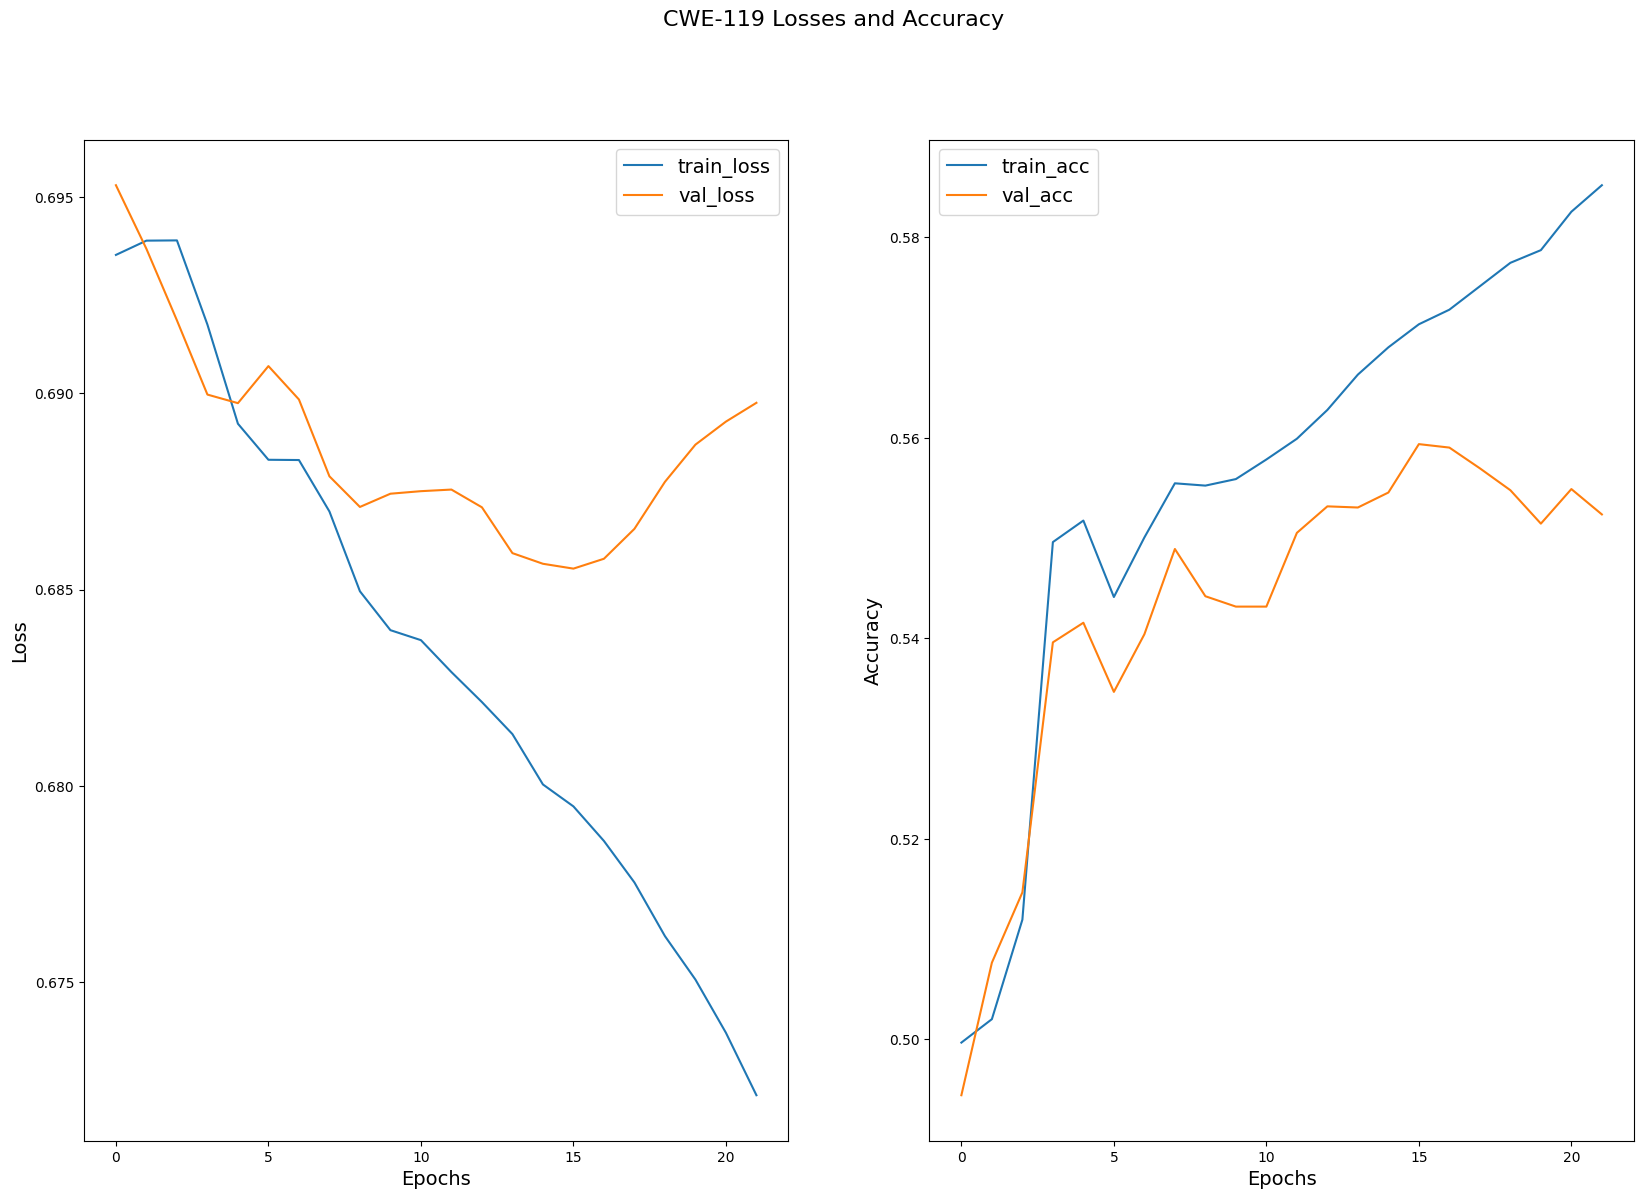

In [29]:
plot_cwe_results("CWE-119", train_losses_119, val_losses_119, train_acc_list_119, val_acc_list_119)

In [30]:
compute_performance_metrics("CWE-119", model_119, x_CWE119_test_tensors, y_CWE119_test_tensors)

CWE-119 Performance Metrics:
 Accuracy : 0.5673563218390805 
 Precision : 0.5790508974674207 
 Recall : 0.5343771272974813 
 F1 : 0.5558177956101016
 MCC : 0.13586458725927608

Confusion Matrix:
[[2581 1712]
 [2052 2355]]


- CWE-120

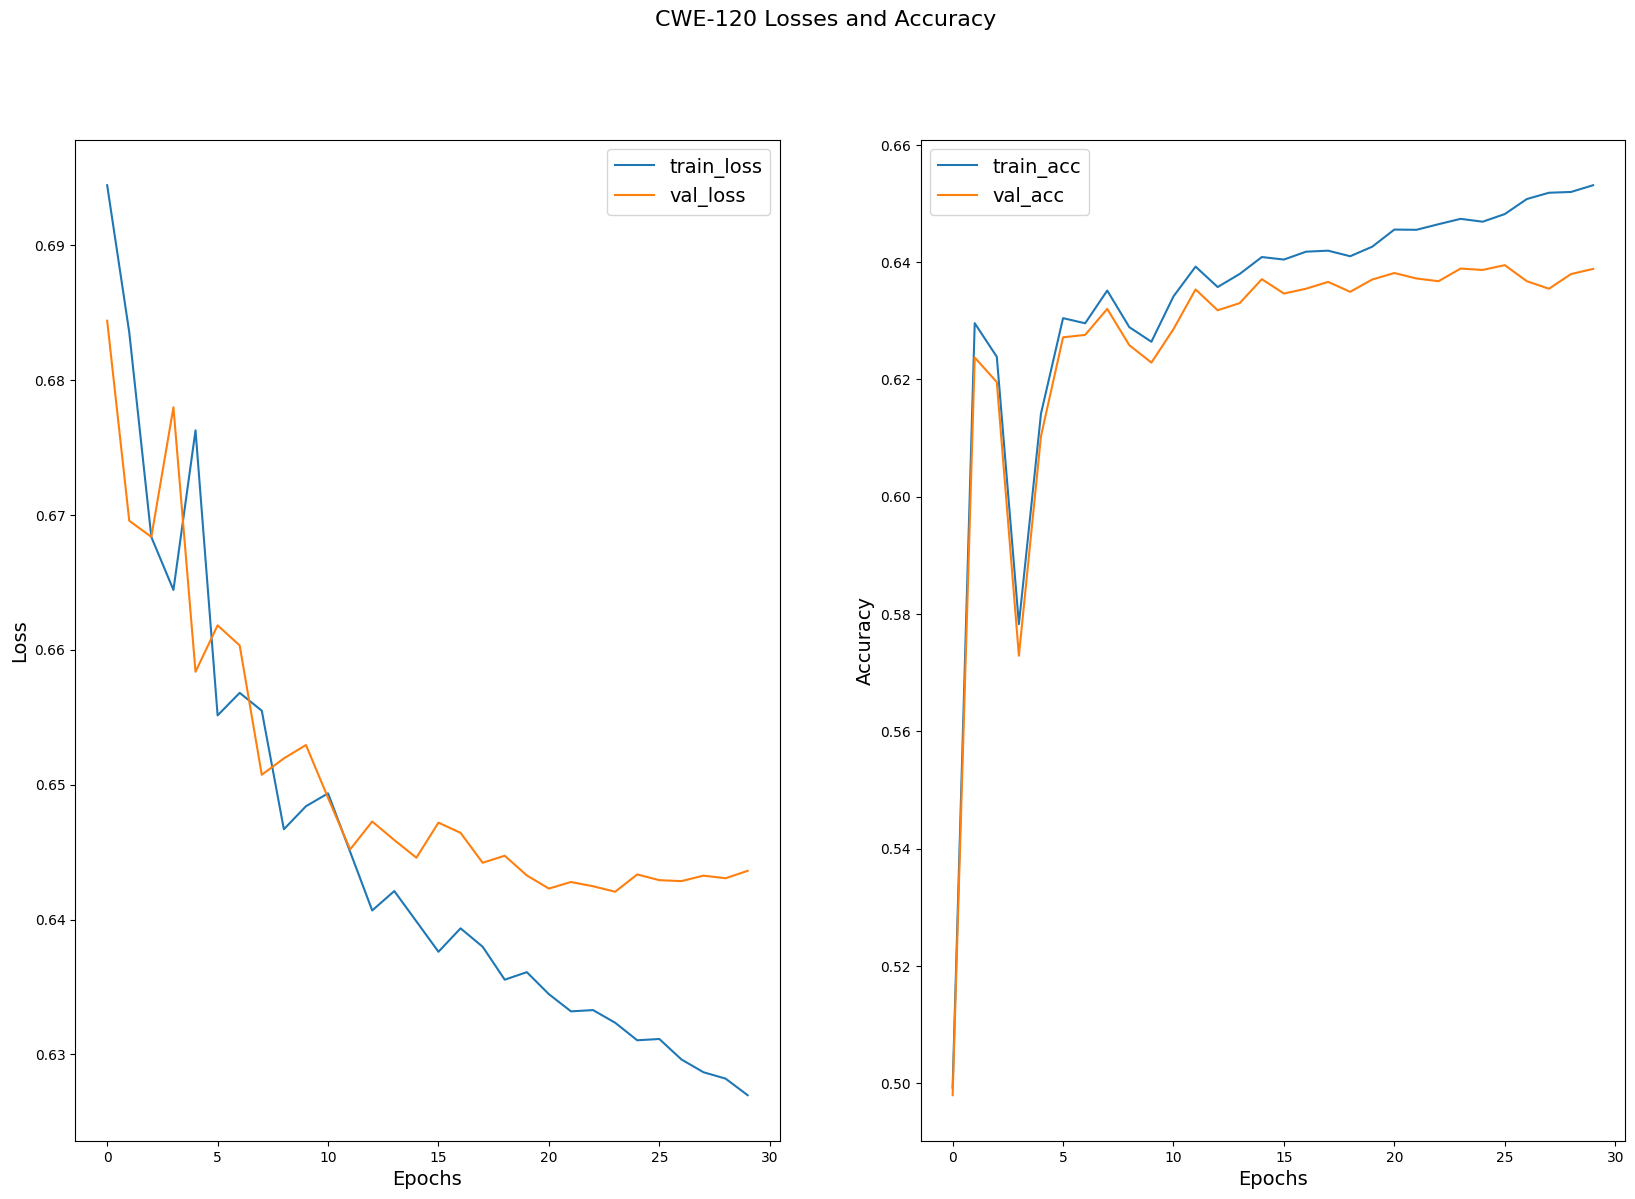

In [31]:
plot_cwe_results("CWE-120", train_losses_120, val_losses_120, train_acc_list_120, val_acc_list_120)

In [32]:
compute_performance_metrics("CWE-120", model_120, x_CWE120_test_tensors, y_CWE120_test_tensors)

CWE-120 Performance Metrics:
 Accuracy : 0.6459232474046425 
 Precision : 0.6422028473678402 
 Recall : 0.6728723404255319 
 F1 : 0.6571799649895532
 MCC : 0.29183284487027744

Confusion Matrix:
[[5256 3242]
 [2829 5819]]


- CWE-469

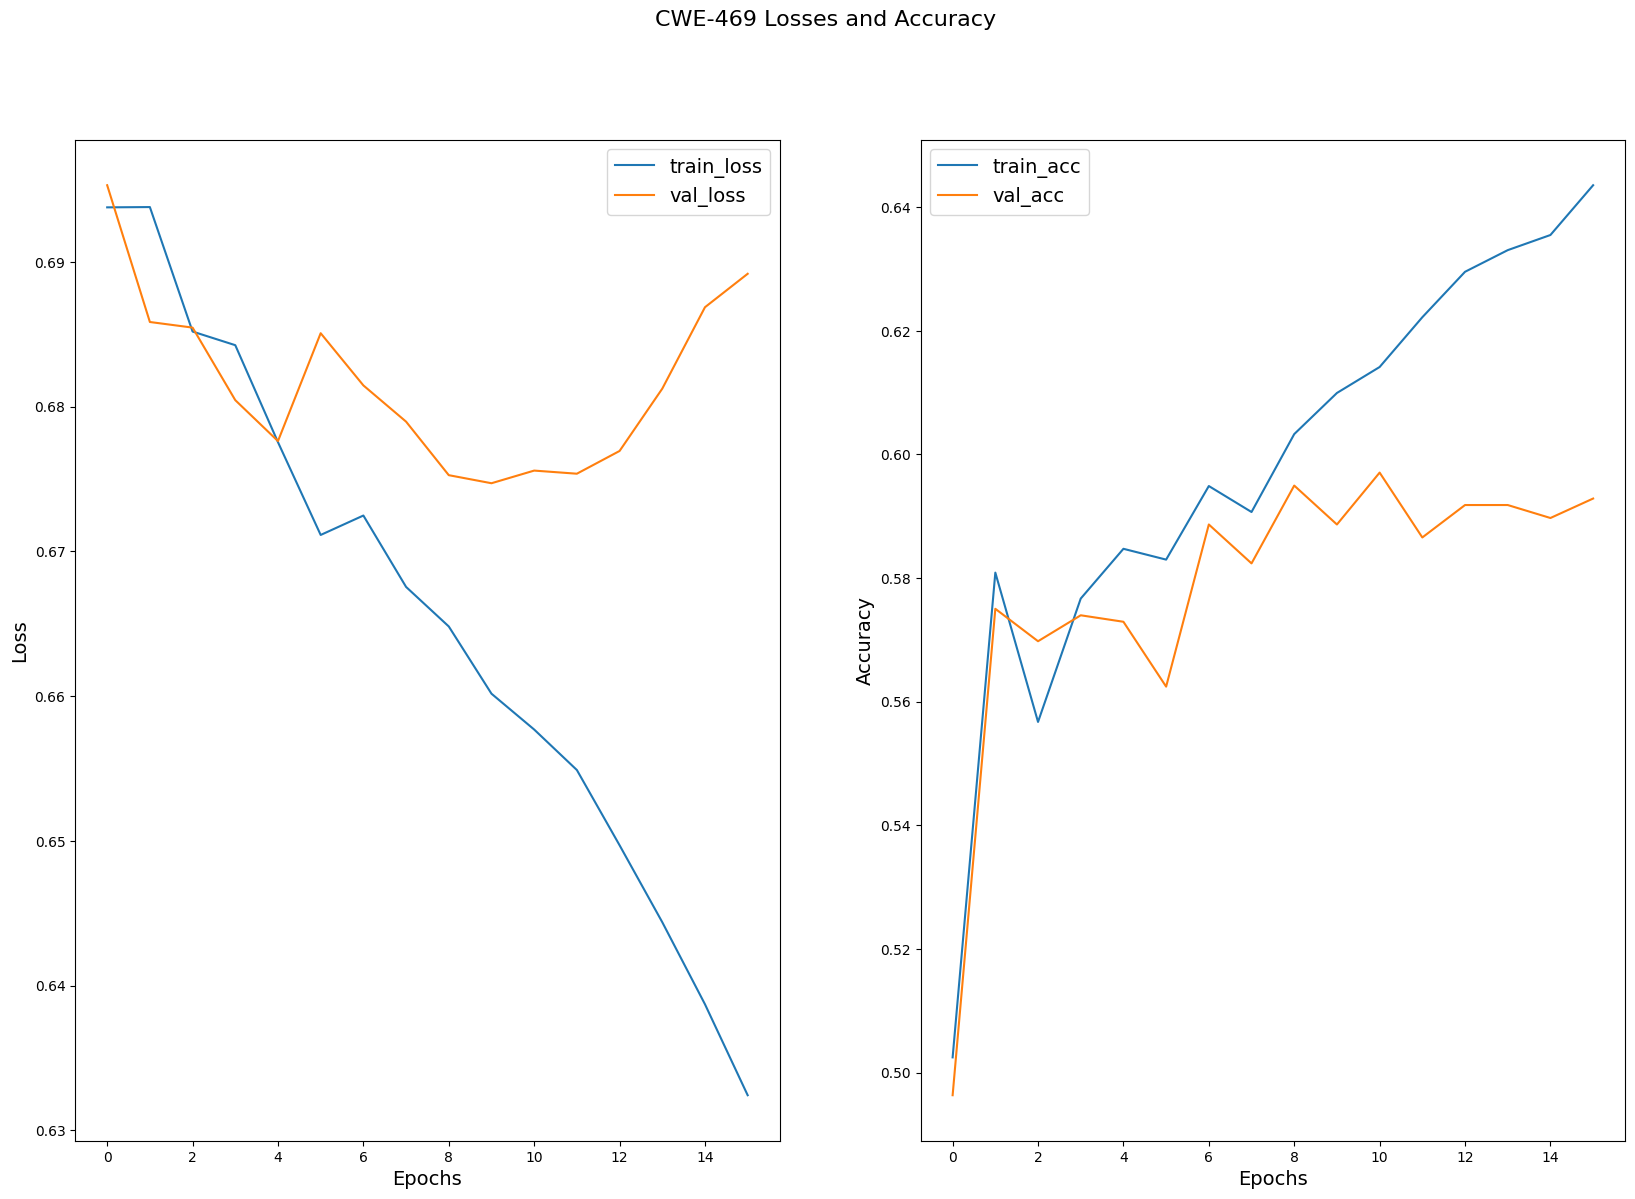

In [33]:
plot_cwe_results("CWE-469", train_losses_469, val_losses_469, train_acc_list_469, val_acc_list_469)

In [34]:
compute_performance_metrics("CWE-469", model_469, x_CWE469_test_tensors, y_CWE469_test_tensors)

CWE-469 Performance Metrics:
 Accuracy : 0.5708289611752361 
 Precision : 0.5820512820512821 
 Recall : 0.4799154334038055 
 F1 : 0.526071842410197
 MCC : 0.14269925724296922

Confusion Matrix:
[[317 163]
 [246 227]]


- CWE-476

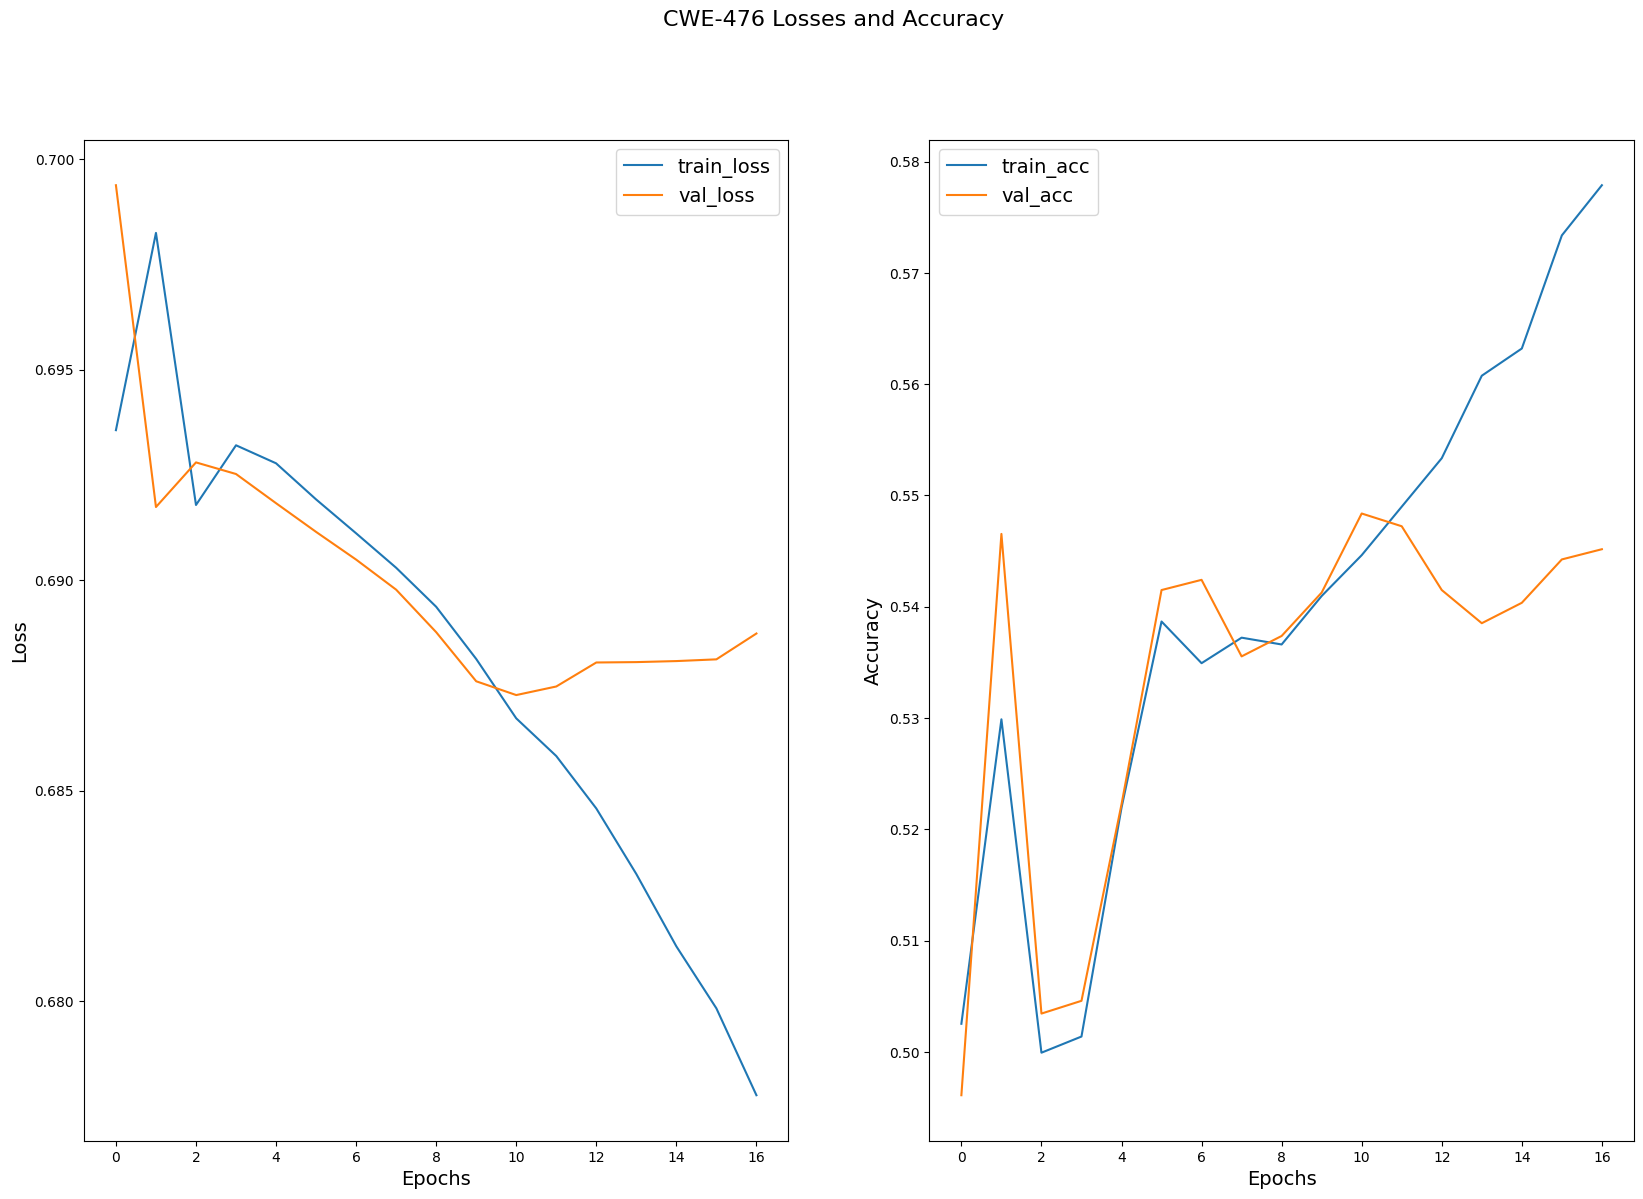

In [35]:
plot_cwe_results("CWE-476", train_losses_476, val_losses_476, train_acc_list_476, val_acc_list_476)

In [36]:
compute_performance_metrics("CWE-476", model_476, x_CWE476_test_tensors, y_CWE476_test_tensors)

CWE-476 Performance Metrics:
 Accuracy : 0.5307198532783127 
 Precision : 0.5338753387533876 
 Recall : 0.538006372325899 
 F1 : 0.5359328950351395
 MCC : 0.06133737862922467

Confusion Matrix:
[[1133 1032]
 [1015 1182]]


- CWE OTHERS

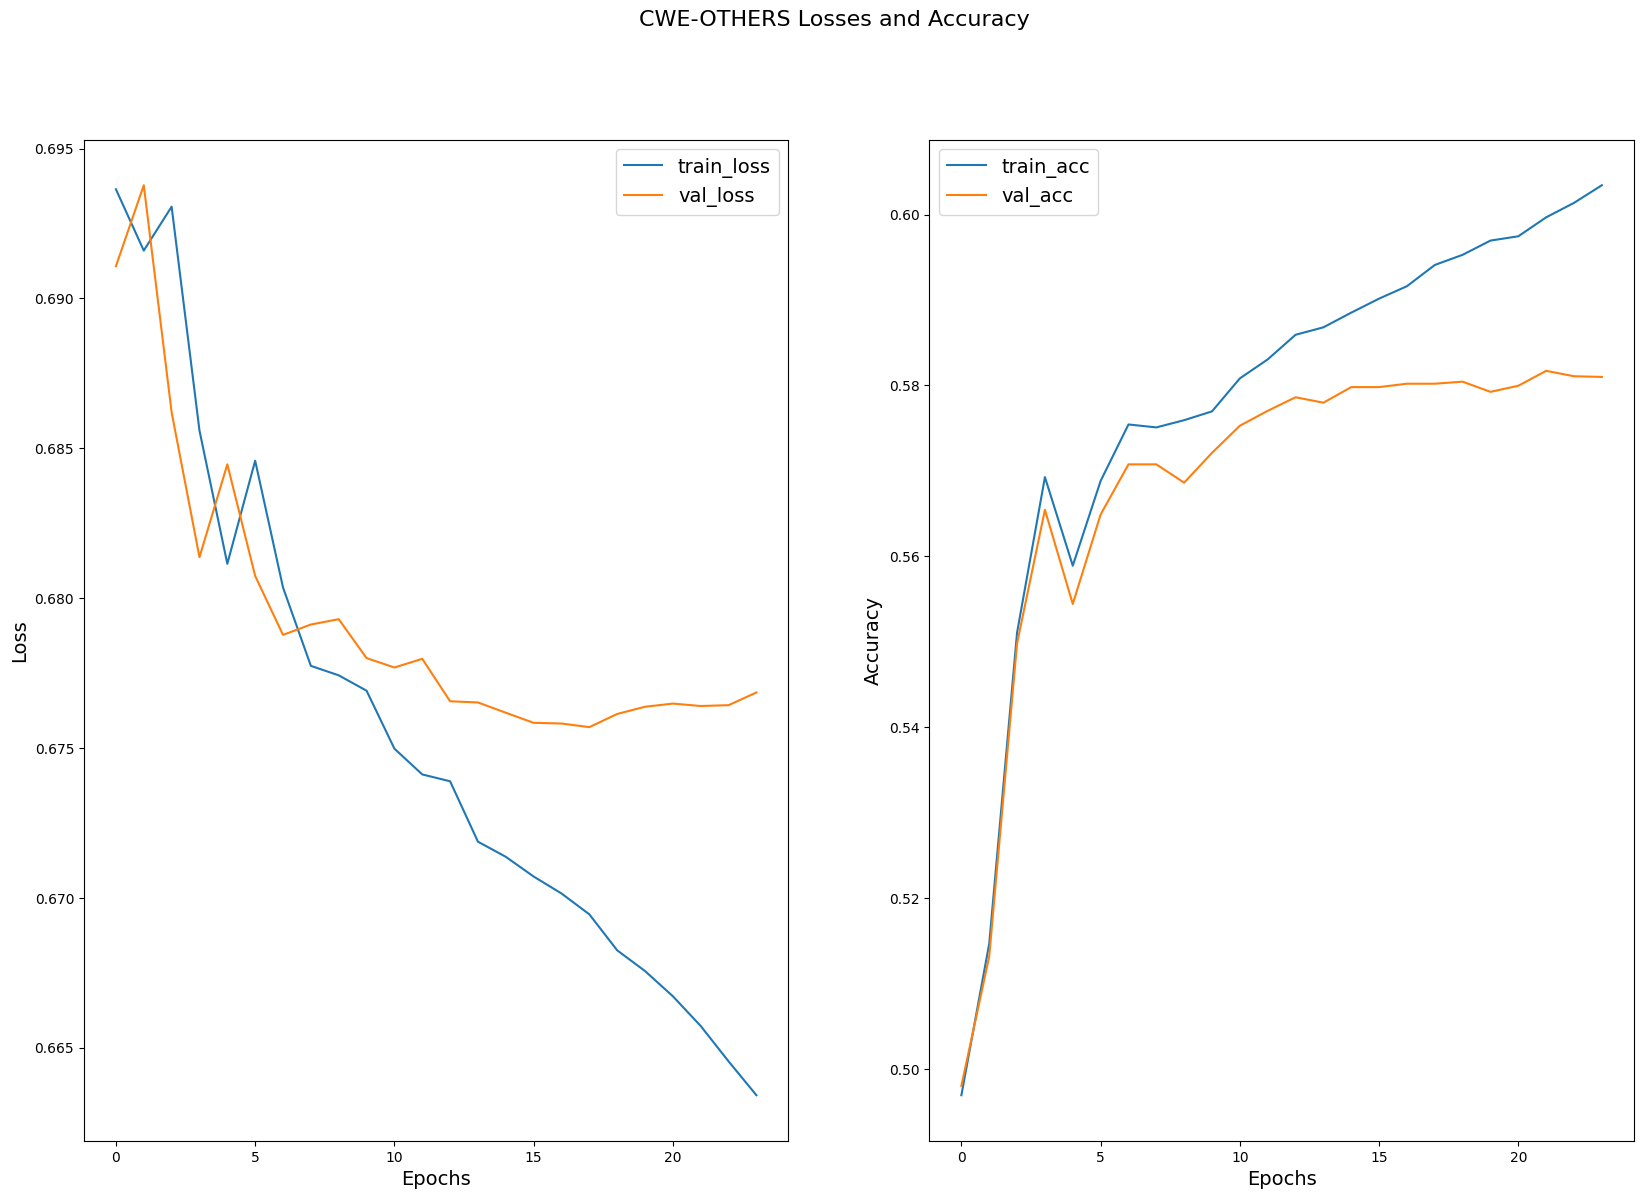

In [37]:
plot_cwe_results("CWE-OTHERS", train_losses_OTHERS, val_losses_OTHERS, train_acc_list_OTHERS, val_acc_list_OTHERS)

In [38]:
compute_performance_metrics("CWE-OTHERS", model_OTHERS, x_CWEOTHERS_test_tensors, y_CWEOTHERS_test_tensors)

CWE-OTHERS Performance Metrics:
 Accuracy : 0.5734676076441202 
 Precision : 0.5972171365800073 
 Recall : 0.5064430988976867 
 F1 : 0.5480971183735194
 MCC : 0.15120346797237033

Confusion Matrix:
[[3970 2200]
 [3179 3262]]


- CWE COMBINED

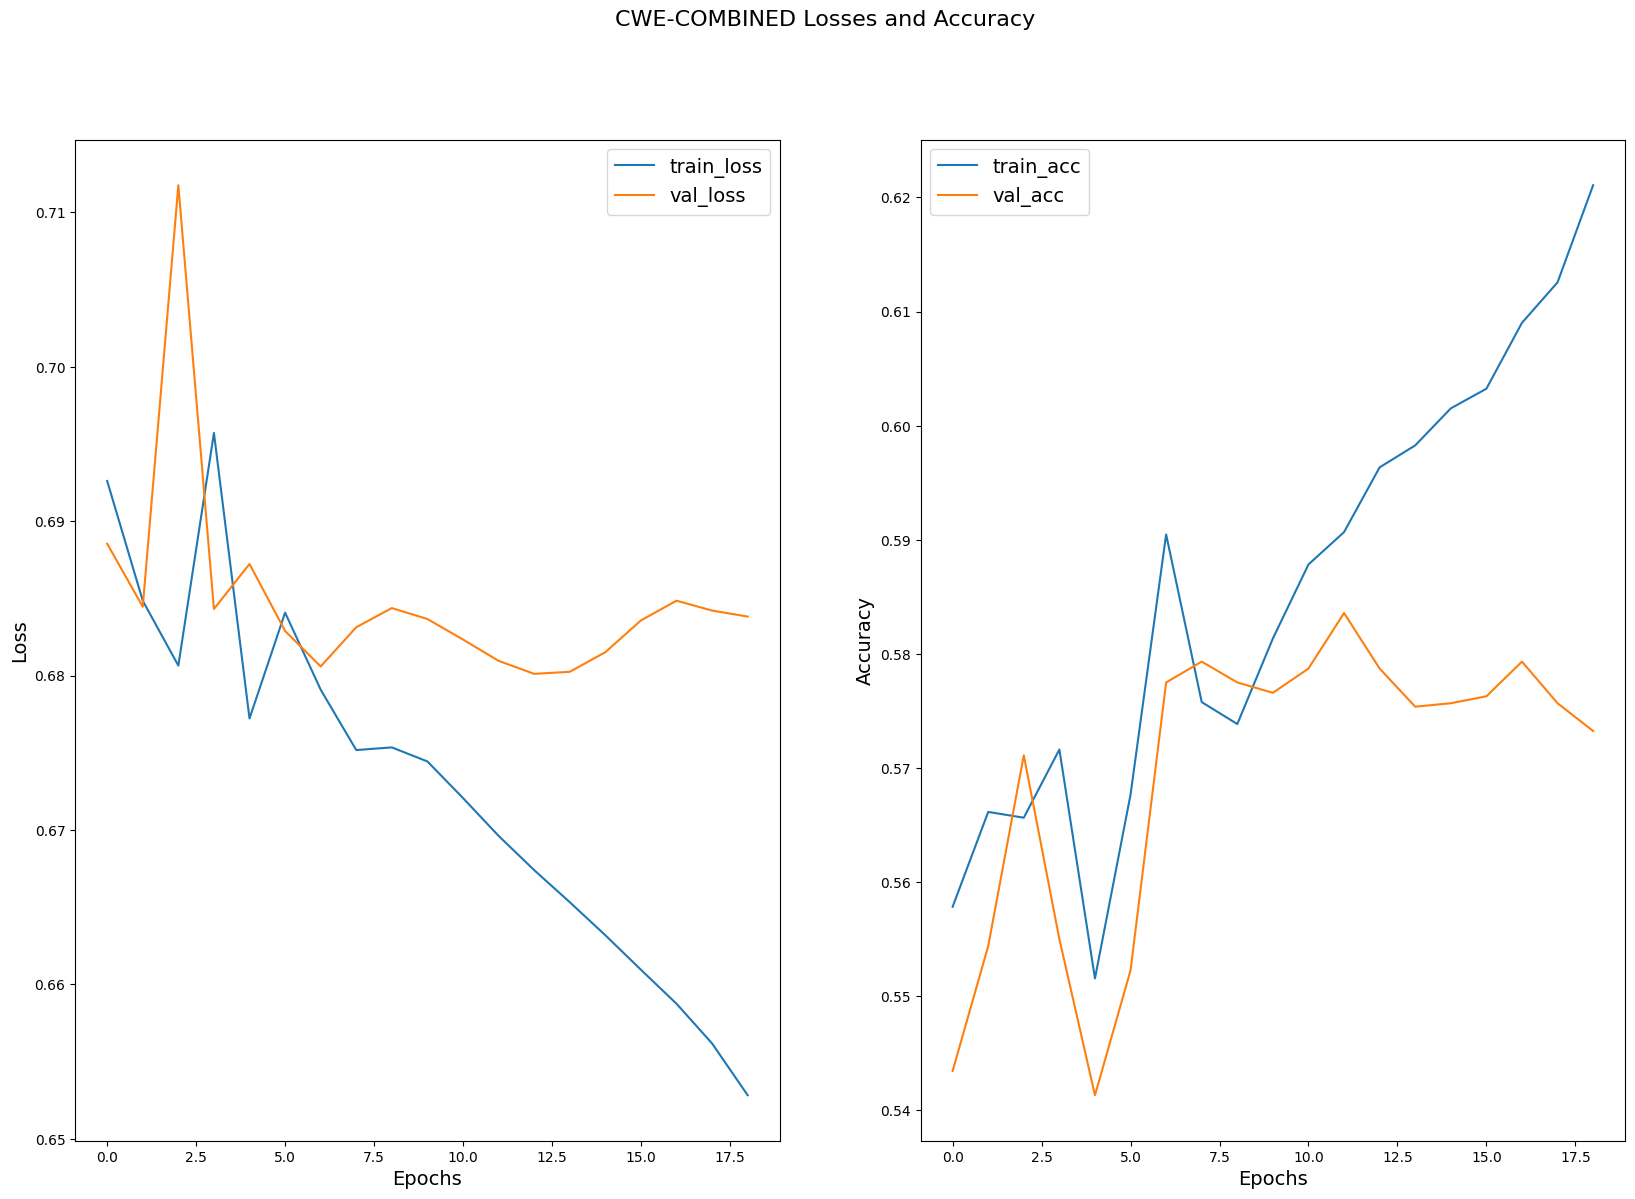

In [39]:
plot_cwe_results("CWE-COMBINED", train_losses_COMBINED, val_losses_COMBINED, train_acc_list_COMBINED, val_acc_list_COMBINED)

In [40]:
compute_performance_metrics("CWE-COMBINED", model_COMBINED, x_COMBINED_test_tensors, y_COMBINED_test_tensors)

CWE-COMBINED Performance Metrics:
 Accuracy : 0.578419452887538 
 Precision : 0.5645756457564576 
 Recall : 0.65625 
 F1 : 0.6069708132615471
 MCC : 0.15994234906664576

Confusion Matrix:
[[ 832  826]
 [ 561 1071]]


### Multilayer Perceptron Mixture Models

Just like we did previously for the GNN, we will now join the models trained for each vulnerability category into a mixture model and compare it agains the model trained with the dataset with all the vulnerabilities joined into one.  

These models are exacly the same as the ones for the GNN, the only difference is that the output of the models isn't stored in the GPU, since these MLP models where trained in the CPU. So we have to make just a slight adjustment to them and consider the output to already be on the RAM instead of the VRAM.

In [41]:
class MixtureWeightsModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureWeightsModel, self).__init__()
        self.models = torch.nn.ModuleList(models)
        self.weights = torch.nn.Parameter(torch.randn(len(models)))

    def forward(self, x):
        # Apply each model to the input and detach the result
        outs = [model(x).detach() for model in self.models]

        # Combine the results using learned weights
        out = torch.stack(outs, dim=0)
        weights = torch.nn.functional.softmax(self.weights, dim=0)
        out = torch.sum(weights[:, None, None] * out, dim=0)

        return out


class MixtureAverageModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureAverageModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Apply each model to the input and detach the result
        outs = [model(x).detach() for model in self.models]

        # Average the results
        out = torch.mean(torch.stack(outs, dim=0), dim=0)

        return out


class MixtureMaxModel(torch.nn.Module):
    def __init__(self, models):
        super(MixtureMaxModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Apply each model to the input and detach the result
        outs = [model(x).detach() for model in self.models]

        # Take the maximum of the results
        out = torch.max(torch.stack(outs, dim=0), dim=0)[0]

        return out


Create our mixture models

In [42]:
mixture_mlp_weights = MixtureWeightsModel([model_119, model_120, model_469, model_476, model_OTHERS])
mixture_mlp_Average = MixtureAverageModel([model_119, model_120, model_469, model_476, model_OTHERS])
mixture_mlp_max = MixtureMaxModel([model_119, model_120, model_469, model_476, model_OTHERS])

Training the Mixture Weights Model

In [43]:
device = torch.device("cpu")
mixture_mlp_weights.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(mixture_mlp_weights.parameters(), lr=0.01)
mixture_mlp_weights.eval()
y_pred = mixture_mlp_weights(x_COMBINED_test_tensors)
loss_before_train = criterion(y_pred.squeeze(), y_COMBINED_test_tensors.float())
print(f'Test loss before training for Mixture Weights Model:', loss_before_train.item())

train_losses_mixture, val_losses_mixture, train_acc_list_mixture, val_acc_list_mixture = train_model(epochs=200, 
                                                                                                     early_stopping_patience=5, 
                                                                                                     train_function=train, 
                                                                                                     evaluate_function=evaluate, 
                                                                                                     x_train_tensors=x_COMBINED_train_tensors,
                                                                                                     y_train_tensors=y_COMBINED_train_tensors,
                                                                                                     x_val_tensors=x_COMBINED_val_tensors, 
                                                                                                     y_val_tensors=y_COMBINED_val_tensors,
                                                                                                     model=mixture_mlp_weights, 
                                                                                                     criterion=criterion,
                                                                                                     optimizer=optimizer)

Test loss before training for Mixture Weights Model: 0.7441393733024597
Starting training...
Epoch 0 | Train Loss 0.7442513704299927 | Train Accuracy 0.49260385005065854 | Validation Accuracy 0.5115501519756839 | Validation loss 0.7343316674232483
Epoch 1 | Train Loss 0.7433876991271973 | Train Accuracy 0.49260385005065854 | Validation Accuracy 0.5115501519756839 | Validation loss 0.7335490584373474
Epoch 2 | Train Loss 0.7425290942192078 | Train Accuracy 0.49260385005065854 | Validation Accuracy 0.5115501519756839 | Validation loss 0.7327717542648315
Epoch 3 | Train Loss 0.7416757345199585 | Train Accuracy 0.49260385005065854 | Validation Accuracy 0.5115501519756839 | Validation loss 0.7319999933242798
Epoch 4 | Train Loss 0.7408280372619629 | Train Accuracy 0.49260385005065854 | Validation Accuracy 0.5115501519756839 | Validation loss 0.7312341332435608
Epoch 5 | Train Loss 0.7399862408638 | Train Accuracy 0.4922998986828774 | Validation Accuracy 0.5115501519756839 | Validation loss 

In [44]:
weights = torch.nn.functional.softmax(mixture_mlp_weights.weights, dim=0)

print(f"Weights:\nCWE-119: {weights[0]}\nCWE-120: {weights[1]}\nCWE-469: {weights[2]}\nCWE-476: {weights[3]}\nCWE-OTHERS: {weights[4]}")

Weights:
CWE-119: 0.03461631014943123
CWE-120: 0.07187969982624054
CWE-469: 0.055936288088560104
CWE-476: 0.8107513189315796
CWE-OTHERS: 0.026816315948963165


Evaluating the models

- Weights mixture

In [45]:
compute_performance_metrics("CWE-COMBINED", mixture_mlp_weights, x_COMBINED_test_tensors, y_COMBINED_test_tensors)

CWE-COMBINED Performance Metrics:
 Accuracy : 0.5279635258358663 
 Precision : 0.5196615231458437 
 Recall : 0.6397058823529411 
 F1 : 0.5734688272452623
 MCC : 0.05914364986731171

Confusion Matrix:
[[ 693  965]
 [ 588 1044]]


- Average Mixture

In [46]:
compute_performance_metrics("CWE-COMBINED", mixture_mlp_Average, x_COMBINED_test_tensors, y_COMBINED_test_tensors)

CWE-COMBINED Performance Metrics:
 Accuracy : 0.4957446808510638 
 Precision : 0.49585762503835534 
 Recall : 0.9901960784313726 
 F1 : 0.6608055612349213
 MCC : -0.003917009139103518

Confusion Matrix:
[[  15 1643]
 [  16 1616]]


- Max Mixture

In [47]:
compute_performance_metrics("CWE-COMBINED", mixture_mlp_max, x_COMBINED_test_tensors, y_COMBINED_test_tensors)

CWE-COMBINED Performance Metrics:
 Accuracy : 0.496048632218845 
 Precision : 0.496048632218845 
 Recall : 1.0 
 F1 : 0.6631450629825275
 MCC : 0.0

Confusion Matrix:
[[   0 1658]
 [   0 1632]]


### XGBoost

We will now test some different models in a attempt to surpass the original results of the author. We will train a XGBoost model, because we think it might perform well enough.

In [48]:
from xgboost import XGBClassifier

In [49]:
# CWE-119
x_CWE119_train, x_CWE119_test, y_CWE119_train, y_CWE119_test = train_test_split(x_CWE119, y_CWE119, test_size=0.2, random_state=1)
# CWE-120
x_CWE120_train, x_CWE120_test, y_CWE120_train, y_CWE120_test = train_test_split(x_CWE120, y_CWE120, test_size=0.2, random_state=1)
# CWE-469
x_CWE469_train, x_CWE469_test, y_CWE469_train, y_CWE469_test = train_test_split(x_CWE469, y_CWE469, test_size=0.2, random_state=1)
# CWE-476
x_CWE476_train, x_CWE476_test, y_CWE476_train, y_CWE476_test = train_test_split(x_CWE476, y_CWE476, test_size=0.2, random_state=1)
# CWE-OTHERS
x_CWEOTHERS_train, x_CWEOTHERS_test, y_CWEOTHERS_train, y_CWEOTHERS_test = train_test_split(x_CWEOTHERS, y_CWEOTHERS, test_size=0.2, random_state=1)
# CWE-COMBINED
x_COMBINED_train, x_COMBINED_test, y_COMBINED_train, y_COMBINED_test = train_test_split(x_COMBINED, y_COMBINED, test_size=0.2, random_state=1)

In [50]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

#### Training

- CWE-119

In [51]:
grid_search_xgb_119 = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_119.fit(x_CWE119_train, y_CWE119_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.5s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [52]:
grid_search_xgb_119.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}

In [53]:
xgb_119 = XGBClassifier(**grid_search_xgb_119.best_params_)
xgb_119.fit(x_CWE119_train, y_CWE119_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- CWE-120

In [54]:
grid_search_xgb_120 = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_120.fit(x_CWE120_train, y_CWE120_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [55]:
grid_search_xgb_120.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

In [56]:
xgb_120 = XGBClassifier(**grid_search_xgb_120.best_params_)
xgb_120.fit(x_CWE120_train, y_CWE120_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- CWE-469

In [57]:
grid_search_xgb_469 = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_469.fit(x_CWE469_train, y_CWE469_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [58]:
grid_search_xgb_469.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [59]:
xgb_469 = XGBClassifier(**grid_search_xgb_469.best_params_)
xgb_469.fit(x_CWE469_train, y_CWE469_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- CWE-476

In [60]:
grid_search_xgb_476 = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_476.fit(x_CWE476_train, y_CWE476_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [61]:
grid_search_xgb_476.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

In [62]:
xgb_476 = XGBClassifier(**grid_search_xgb_476.best_params_)
xgb_476.fit(x_CWE476_train, y_CWE476_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- CWE-OTHERS

In [63]:
grid_search_xgb_OTHERS = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_OTHERS.fit(x_CWEOTHERS_train, y_CWEOTHERS_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.9s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [64]:
grid_search_xgb_OTHERS.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [65]:
xgb_OTHERS = XGBClassifier(**grid_search_xgb_OTHERS.best_params_)
xgb_OTHERS.fit(x_CWEOTHERS_train, y_CWEOTHERS_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

- CWE-COMBINED


In [66]:
grid_search_xgb_COMBINED = GridSearchCV(estimator=XGBClassifier(nthread=2, tree_method='gpu_hist'), param_grid=param_grid, cv=5, verbose=2)
grid_search_xgb_COMBINED.fit(x_COMBINED_train, y_COMBINED_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=2,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [67]:
grid_search_xgb_COMBINED.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [68]:
xgb_COMBINED = XGBClassifier(**grid_search_xgb_COMBINED.best_params_)
xgb_COMBINED.fit(x_COMBINED_train, y_COMBINED_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Evaluation of the models

In [69]:
def calculate_metrics(y_test, x_test, model):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    matthews = matthews_corrcoef(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("F1 score: ", f1)
    print("Recall: ", recall)
    print("Matthews correlation coefficient: ", matthews)
    print("Confusion matrix: \n", confusion)


- CWE-119

In [70]:
calculate_metrics(y_CWE119_test, x_CWE119_test, xgb_119)

Accuracy:  0.5616091954022988
Precision:  0.5678644998855573
F1 score:  0.5654056517775753
Recall:  0.5629680054458815
Matthews correlation coefficient:  0.12317290706219157
Confusion matrix: 
 [[2405 1888]
 [1926 2481]]


- CWE-120

In [71]:
calculate_metrics(y_CWE120_test, x_CWE120_test, xgb_120)

Accuracy:  0.6425405342353901
Precision:  0.6389409817981246
F1 score:  0.6539829503754304
Recall:  0.669750231267345
Matthews correlation coefficient:  0.28505970993569313
Confusion matrix: 
 [[5225 3273]
 [2856 5792]]


- CWE-469

In [72]:
calculate_metrics(y_CWE469_test, x_CWE469_test, xgb_469)

Accuracy:  0.5739769150052466
Precision:  0.5852417302798982
F1 score:  0.5311778290993072
Recall:  0.48625792811839325
Matthews correlation coefficient:  0.14897582441512366
Confusion matrix: 
 [[317 163]
 [243 230]]


- CWE-476

In [73]:
calculate_metrics(y_CWE476_test, x_CWE476_test, xgb_476)

Accuracy:  0.5534158642824393
Precision:  0.5537332757876564
F1 score:  0.5684536996012405
Recall:  0.5839781520254893
Matthews correlation coefficient:  0.10658455837982471
Confusion matrix: 
 [[1131 1034]
 [ 914 1283]]


- CWE-OTHERS

In [74]:
calculate_metrics(y_CWEOTHERS_test, x_CWEOTHERS_test, xgb_OTHERS)

Accuracy:  0.572119578146063
Precision:  0.5902573846951115
F1 score:  0.558789860997547
Recall:  0.5305076851420587
Matthews correlation coefficient:  0.14652550948525814
Confusion matrix: 
 [[3798 2372]
 [3024 3417]]


- CWE-COMBINED

In [75]:
calculate_metrics(y_COMBINED_test, x_COMBINED_test, xgb_COMBINED)

Accuracy:  0.574468085106383
Precision:  0.5696278511404562
F1 score:  0.5755003032140692
Recall:  0.5814950980392157
Matthews correlation coefficient:  0.14905385646314392
Confusion matrix: 
 [[941 717]
 [683 949]]


### SVM

Lastly, we will train a Support Vector Machine model

In [76]:
from sklearn.svm import SVC

#### Training

In [77]:
param_grid_svc = {
    'C' : [0.1, 1],
    'kernel': ['rbf']
}

- CWE-119

In [78]:
grid_search_svc_119 = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_119.fit(x_CWE119_train, y_CWE119_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.2min
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.2min
[CV] END ....................................C=1, kernel=rbf; total time= 1.2min
[CV] END ....................................C=1, kernel=rbf; total time= 1.1min


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [79]:
grid_search_svc_119.best_params_

{'C': 0.1, 'kernel': 'rbf'}

In [82]:
svc_119 = SVC(**grid_search_svc_119.best_params_)
svc_119.fit(x_CWE119_train, y_CWE119_train)

SVC(C=0.1)

- CWE-120

In [83]:
grid_search_svc_120 = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_120.fit(x_CWE120_train, y_CWE120_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time= 4.2min
[CV] END ..................................C=0.1, kernel=rbf; total time= 4.3min
[CV] END ....................................C=1, kernel=rbf; total time= 5.2min
[CV] END ....................................C=1, kernel=rbf; total time= 6.1min


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [84]:
grid_search_svc_120.best_params_

{'C': 1, 'kernel': 'rbf'}

In [85]:
svc_120 = SVC(**grid_search_svc_120.best_params_)
svc_120.fit(x_CWE120_train, y_CWE120_train)

SVC(C=1)

- CWE-469

In [86]:
grid_search_svc_469 = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_469.fit(x_CWE469_train, y_CWE469_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.8s
[CV] END ....................................C=1, kernel=rbf; total time=   0.7s
[CV] END ....................................C=1, kernel=rbf; total time=   0.7s


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [87]:
grid_search_svc_469.best_params_

{'C': 0.1, 'kernel': 'rbf'}

In [88]:
svc_469 = SVC(**grid_search_svc_469.best_params_)
svc_469.fit(x_CWE469_train, y_CWE469_train)

SVC(C=0.1)

- CWE-476

In [89]:
grid_search_svc_476 = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_476.fit(x_CWE476_train, y_CWE476_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=  15.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=  15.7s
[CV] END ....................................C=1, kernel=rbf; total time=  15.5s
[CV] END ....................................C=1, kernel=rbf; total time=  15.6s


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [90]:
grid_search_svc_476.best_params_

{'C': 1, 'kernel': 'rbf'}

In [91]:
svc_476 = SVC(**grid_search_svc_476.best_params_)
svc_476.fit(x_CWE476_train, y_CWE476_train)

SVC(C=1)

- CWE-OTHERS

In [92]:
grid_search_svc_others = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_others.fit(x_CWEOTHERS_train, y_CWEOTHERS_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time= 2.1min
[CV] END ..................................C=0.1, kernel=rbf; total time= 2.1min
[CV] END ....................................C=1, kernel=rbf; total time= 2.6min
[CV] END ....................................C=1, kernel=rbf; total time= 2.3min


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [93]:
grid_search_svc_others.best_params_

{'C': 1, 'kernel': 'rbf'}

In [94]:
svc_others = SVC(**grid_search_svc_others.best_params_)
svc_others.fit(x_CWEOTHERS_train, y_CWEOTHERS_train)

SVC(C=1)

- CWE-COMBINED

In [95]:
grid_search_svc_combined = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=2, verbose=2)
grid_search_svc_combined.fit(x_COMBINED_train, y_COMBINED_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   9.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   9.2s
[CV] END ....................................C=1, kernel=rbf; total time=   9.2s
[CV] END ....................................C=1, kernel=rbf; total time=   9.3s


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf']}, verbose=2)

In [96]:
grid_search_svc_combined.best_params_

{'C': 1, 'kernel': 'rbf'}

In [97]:
svc_combined = SVC(**grid_search_svc_combined.best_params_)
svc_combined.fit(x_COMBINED_train, y_COMBINED_train)

SVC(C=1)

#### Evaluation

- CWE-119

In [98]:
calculate_metrics(y_CWE119_test, x_CWE119_test, svc_119)

Accuracy:  0.5677011494252874
Precision:  0.5660801963993454
F1 score:  0.5953738569123184
Recall:  0.6278647606081235
Matthews correlation coefficient:  0.13482833539893713
Confusion matrix: 
 [[2172 2121]
 [1640 2767]]


- CWE-120

In [99]:
calculate_metrics(y_CWE120_test, x_CWE120_test, svc_120)

Accuracy:  0.6482561530386096
Precision:  0.6498682854197686
F1 score:  0.6529719776742045
Recall:  0.6561054579093432
Matthews correlation coefficient:  0.29641275924853444
Confusion matrix: 
 [[5441 3057]
 [2974 5674]]


- CWE-469

In [100]:
calculate_metrics(y_CWE469_test, x_CWE469_test, svc_469)

Accuracy:  0.5666316894018888
Precision:  0.5714285714285714
F1 score:  0.5375139977603584
Recall:  0.507399577167019
Matthews correlation coefficient:  0.1333366493653234
Confusion matrix: 
 [[300 180]
 [233 240]]


- CWE-476

In [101]:
calculate_metrics(y_CWE476_test, x_CWE476_test, svc_476)

Accuracy:  0.5508940852819807
Precision:  0.5468873128447597
F1 score:  0.586272439281943
Recall:  0.6317705962676377
Matthews correlation coefficient:  0.10196532506063838
Confusion matrix: 
 [[1015 1150]
 [ 809 1388]]


- CWE-OTHERS

In [103]:
calculate_metrics(y_CWEOTHERS_test, x_CWEOTHERS_test, svc_others)

Accuracy:  0.5695028150027753
Precision:  0.5923694779116466
F1 score:  0.5445087675140533
Recall:  0.503803757180562
Matthews correlation coefficient:  0.1430961022407064
Confusion matrix: 
 [[3937 2233]
 [3196 3245]]


- CWE-COMBINED

In [104]:
calculate_metrics(y_COMBINED_test, x_COMBINED_test, svc_combined)

Accuracy:  0.5866261398176292
Precision:  0.5761478163493841
F1 score:  0.6021064950263311
Recall:  0.6305147058823529
Matthews correlation coefficient:  0.17457757609435764
Confusion matrix: 
 [[ 901  757]
 [ 603 1029]]
